### TYK2 IL-23 RNA-seq Assay Combined Analysis

In [29]:
library(ggpubr)
library(tximport)
library(DESeq2)
library(ggcorrplot)
library(furrr)
library(ggbiplot)
library(fs)
library(patchwork)
library(GGally)
library(rhdf5)
library(ComplexHeatmap)
library(tidyverse)

#### Dataset Properties <a name="part1"></a>

In [5]:
alignments <- read_tsv("../pipeline/RNASEQ/diffexp/multiqc_data/multiqc_star.txt") %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

count_summary <- read_tsv("../pipeline/RNASEQ/diffexp/multiqc_data/multiqc_featureCounts.txt")  %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

Rows: 80 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (26): insertion_length, num_GCAG_splices, multimapped_toomany_percent, i...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 80 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (16): Unassigned_Secondary, Unassigned_FragmentLength, Unassigned_Chimer...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


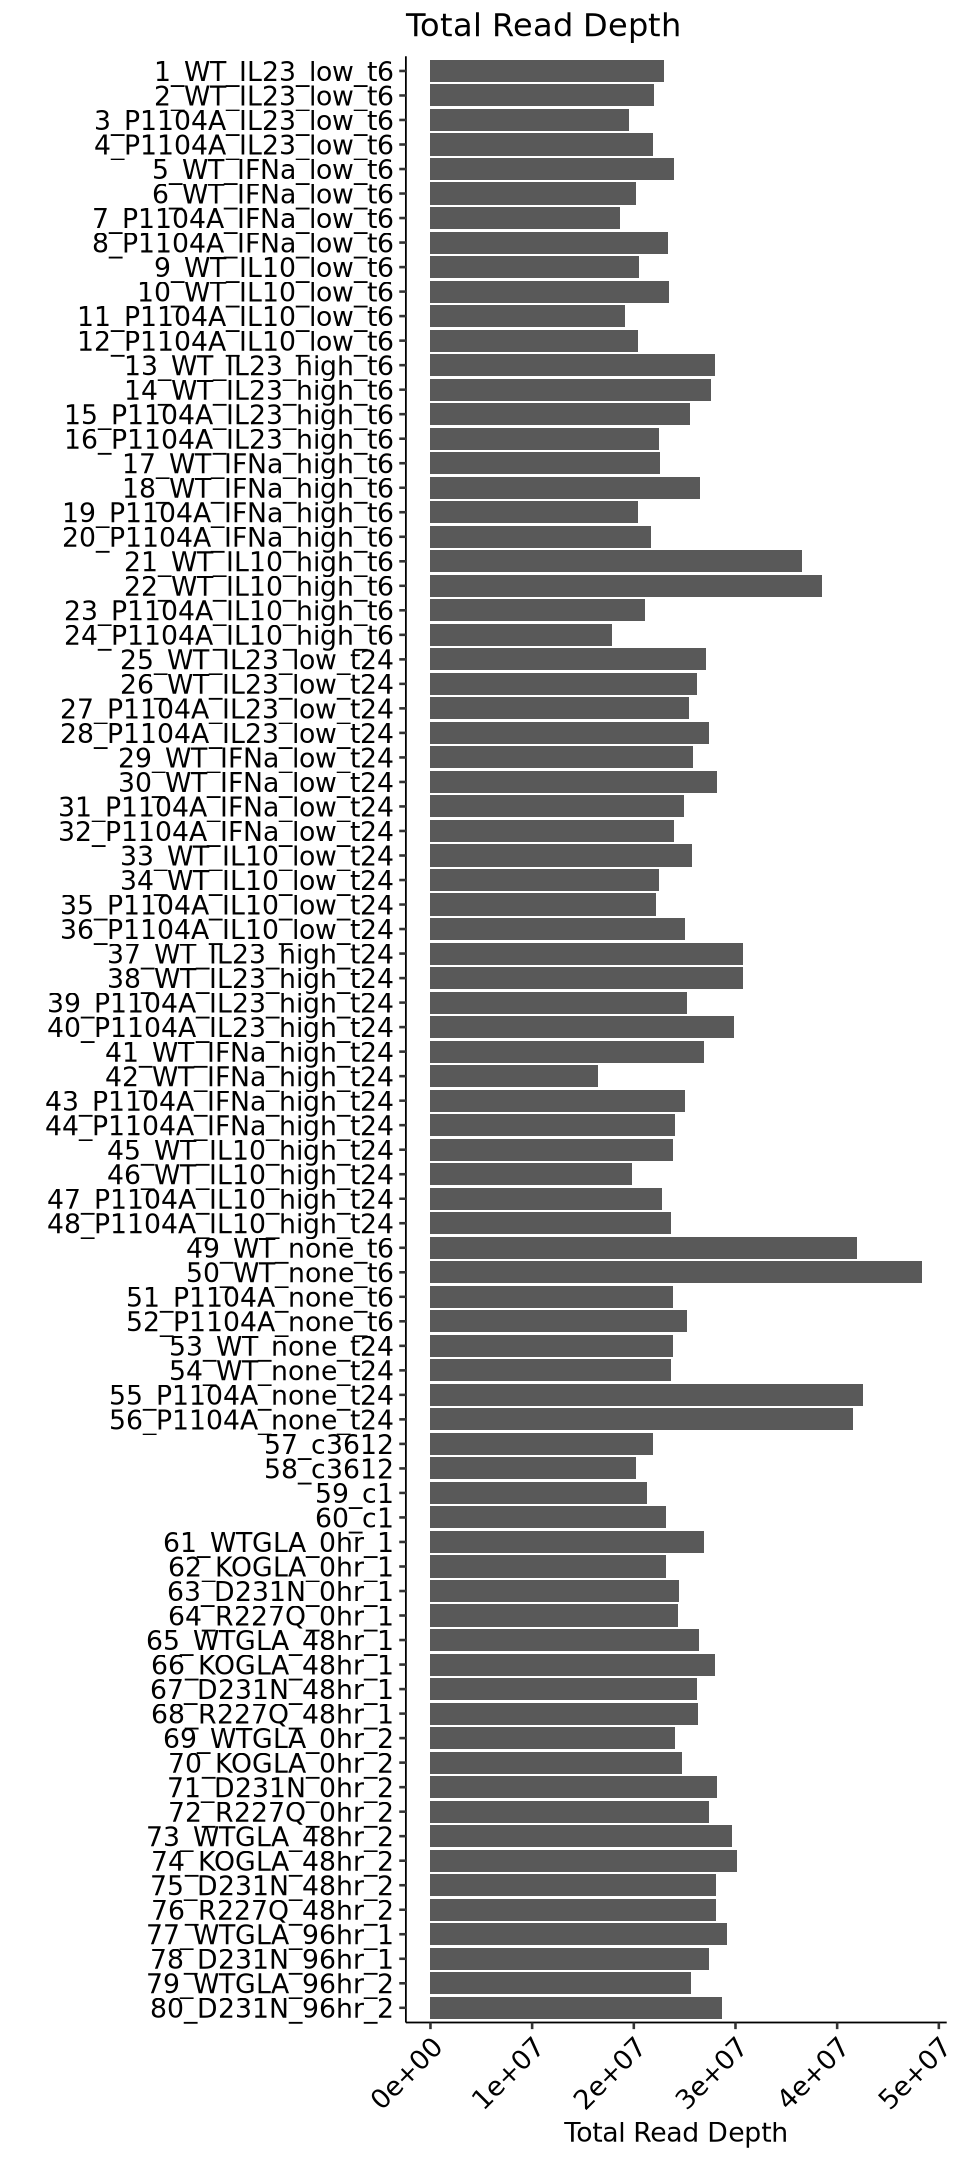

In [6]:
options(repr.plot.width = 8, repr.plot.height = 18)
alignments %>%
    ggplot() +
        geom_bar(aes(x = total_reads, y = reorder(Sample, -id)), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Total Read Depth") + ylab("") +
        ggtitle("Total Read Depth")

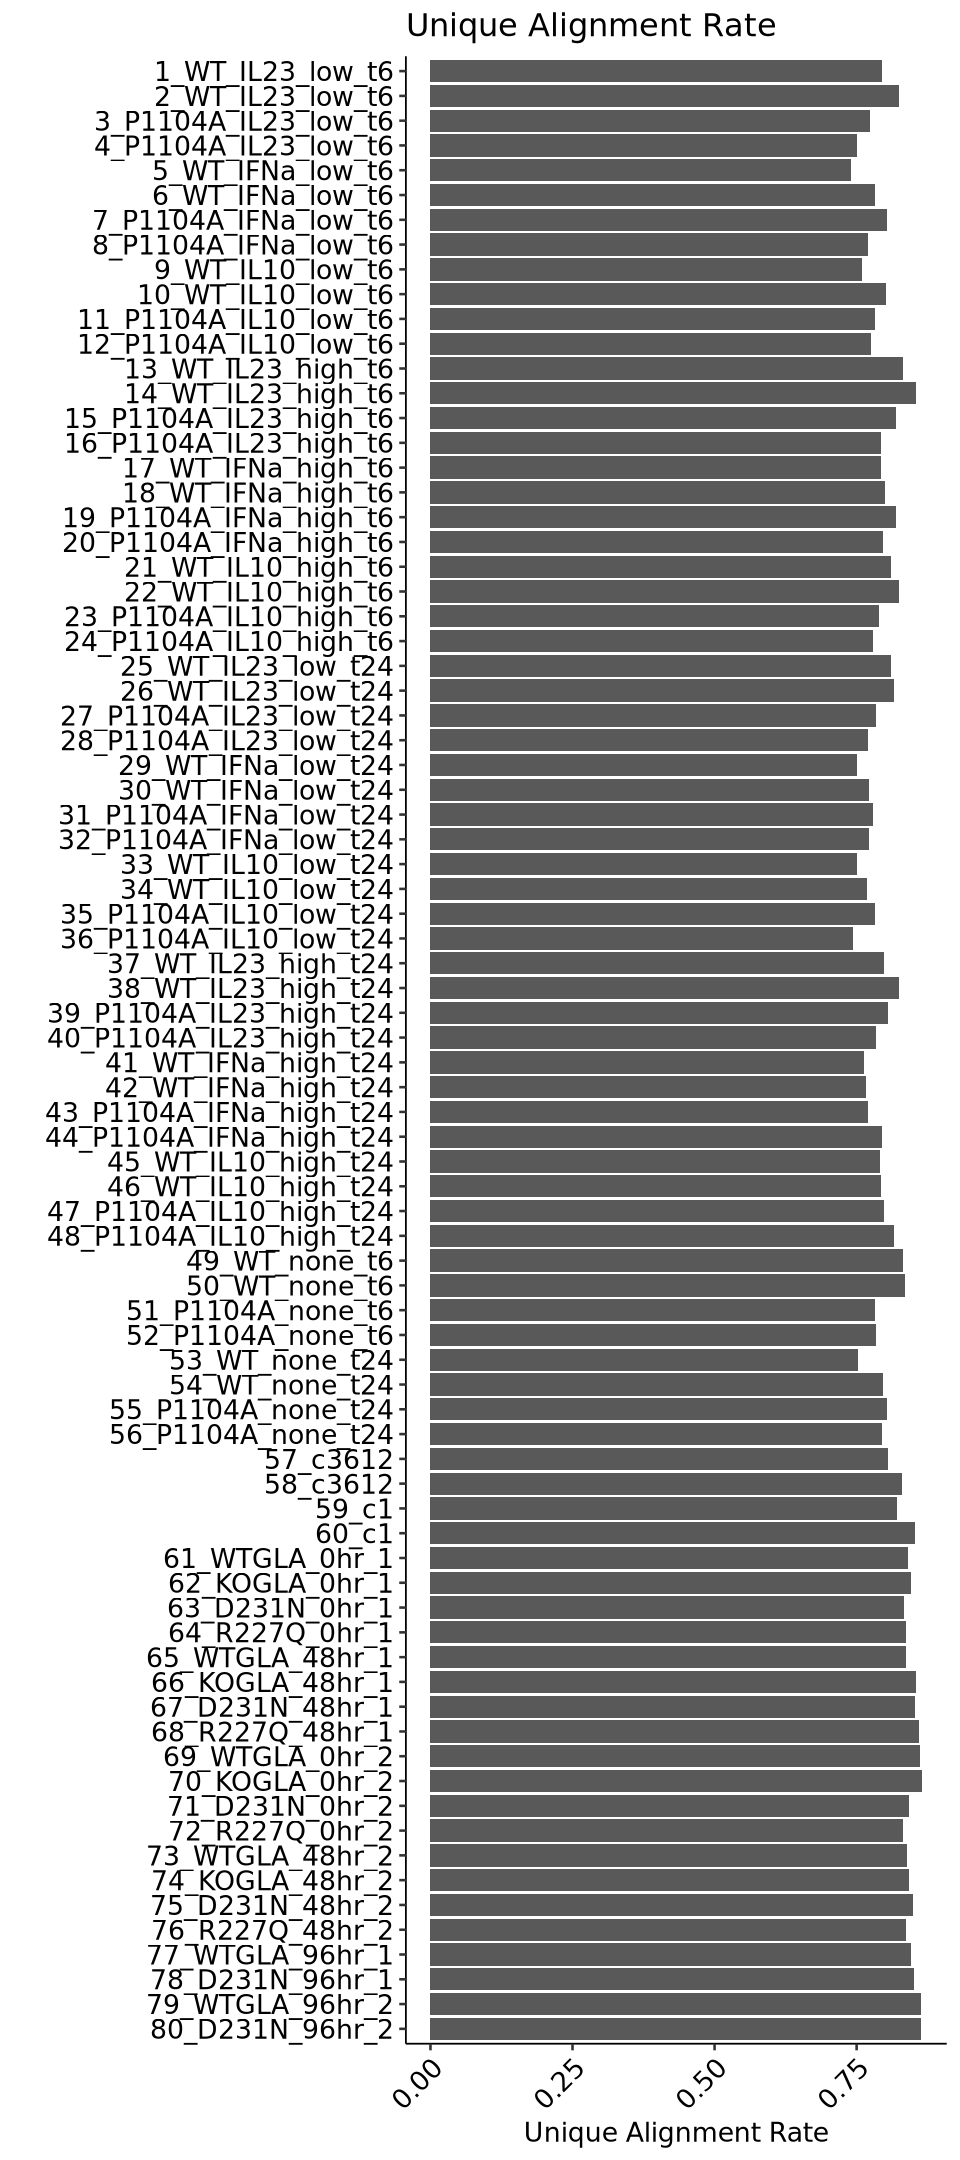

In [7]:
alignments %>%
    ggplot() +
        geom_bar(aes(x = uniquely_mapped_percent/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Unique Alignment Rate") + ylab("") +
        ggtitle("Unique Alignment Rate")

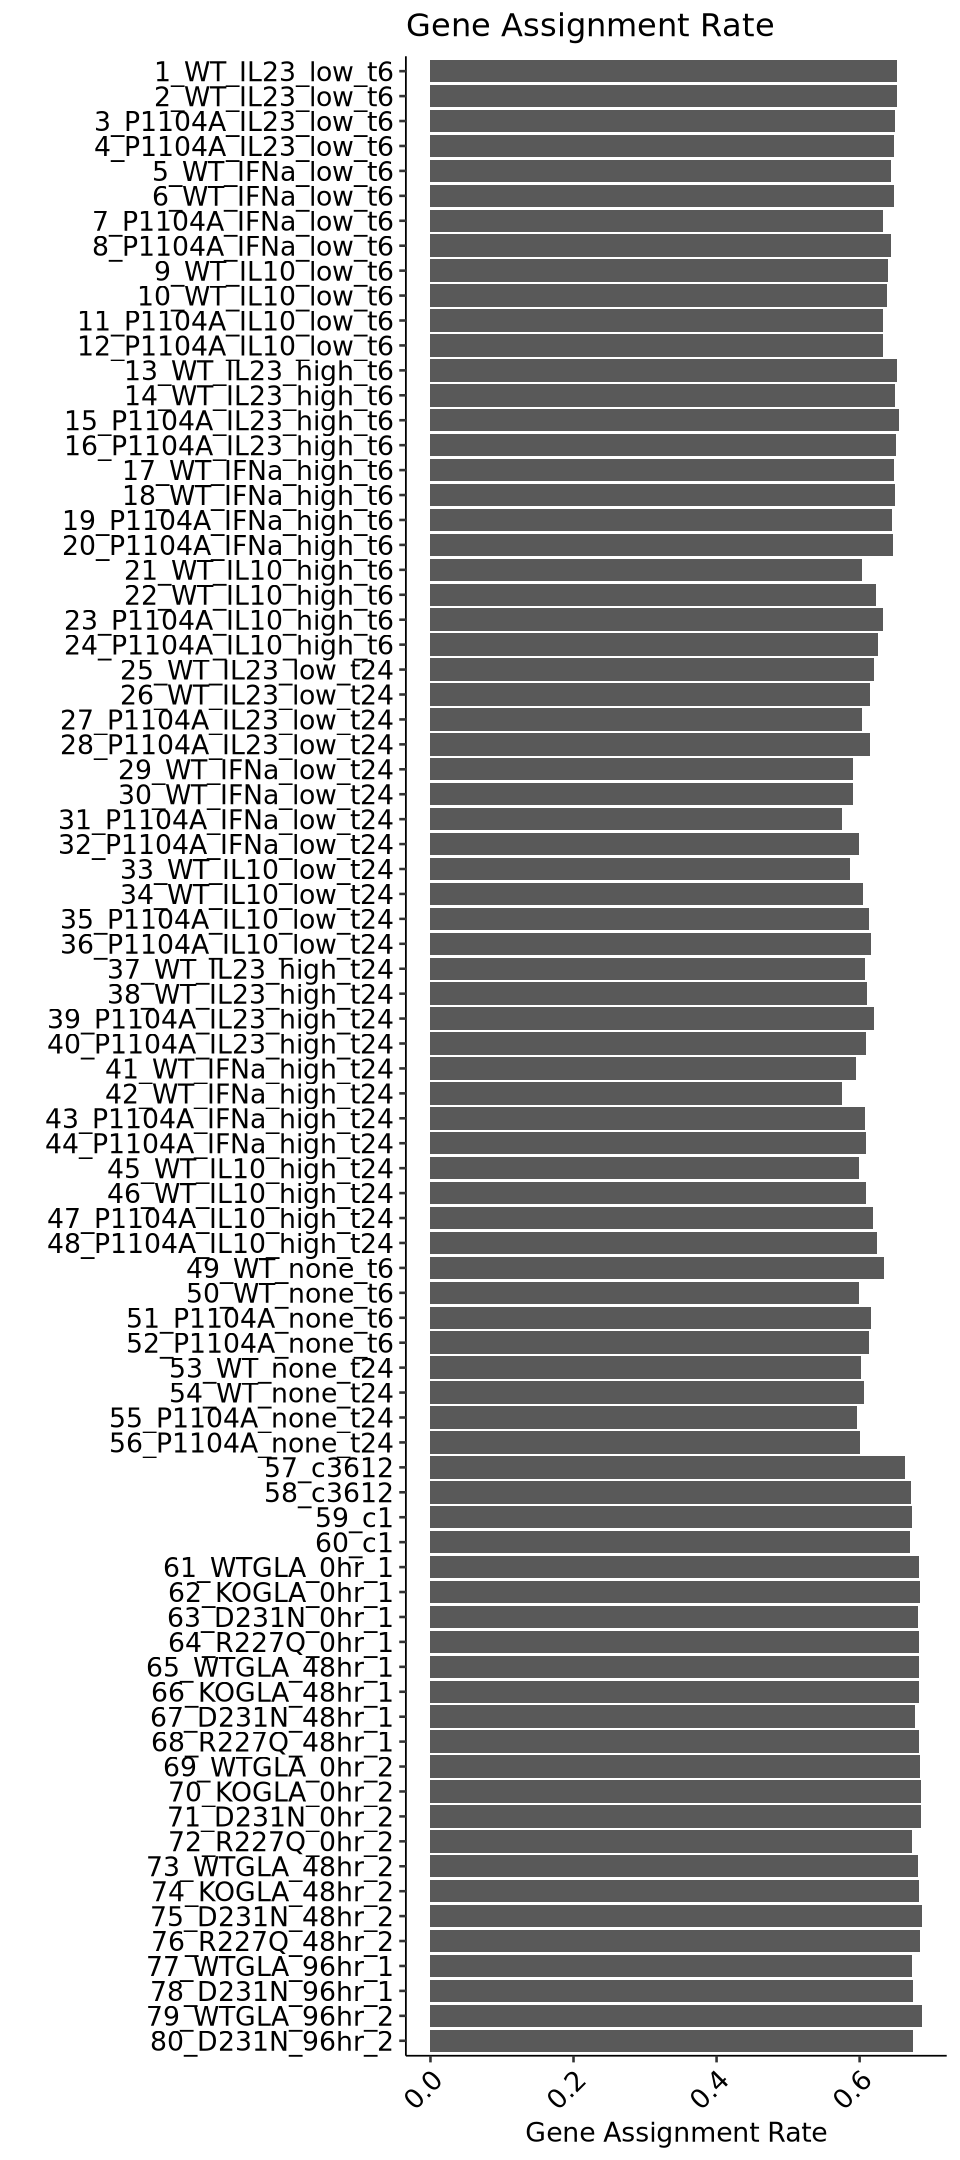

In [8]:
count_summary %>%
    ggplot() +
        geom_bar(aes(x = percent_assigned/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Gene Assignment Rate") + ylab("") +
        ggtitle("Gene Assignment Rate")

#### Unsupervised Profiles <a name="part2"></a>

In [13]:
paths <- str_c("../pipeline/RNASEQ/diffexp/",
                    alignments$Sample,
                    ".counts.tsv")
names(paths) <- paths

df <- map_dfr(paths,
              ~read_tsv(.x,
                        col_names = NULL,
                        skip = 2,
                        col_select = c(1,7)),
              .id = "sample") %>%
    rename("gene" = "X1",
           "count" = "X7") %>%
    mutate(sample = gsub("../pipeline/RNASEQ/diffexp/|.counts.tsv", "", sample))

df_id <- df %>%
    mutate(id = as.character(gsub("_.*", "", sample))) %>%
    select(-sample) %>%
    arrange(id)

Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────

In [56]:
samp_prop <- read_tsv("../sumstats/RNASEQ/run2/sample-properties-il23.tsv") %>%
    arrange(sample_id) %>%
    mutate(rep = rep(c(1,2), 40),
           covariate = as.factor(str_c(group, "_", cytokine, "_", dosage, "_", time)),
           sample_id = as.character(sample_id))
rownames(samp_prop) <- samp_prop$sample_id

Rows: 80 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): group, cytokine, dosage, time
dbl (1): sample_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Setting row names on a tibble is deprecated.”


In [37]:
count_matrix <- inner_join(df_id, samp_prop, by = c("id" = "sample_id")) %>%
    filter(!is.na(covariate)) %>%
    arrange(time, group, cytokine, dosage, rep) %>%
    select(gene, covariate, rep, count)

count_matrix %>%
    count(gene) %>%
    dim()

[1] 60607     2

In [38]:
count_matrix_nonzero <- count_matrix %>%
    group_by(gene) %>%
    filter(sum(count) > 0)

count_matrix_nonzero %>%
    count(gene) %>%
    dim()

[1] 35605     2

In [39]:
count_matrix_thresh <- count_matrix_nonzero %>%
    group_by(gene) %>%
    filter(sum(count > 100) >= 2)

count_matrix_thresh %>%
    count(gene) %>%
    dim()

[1] 10105     2

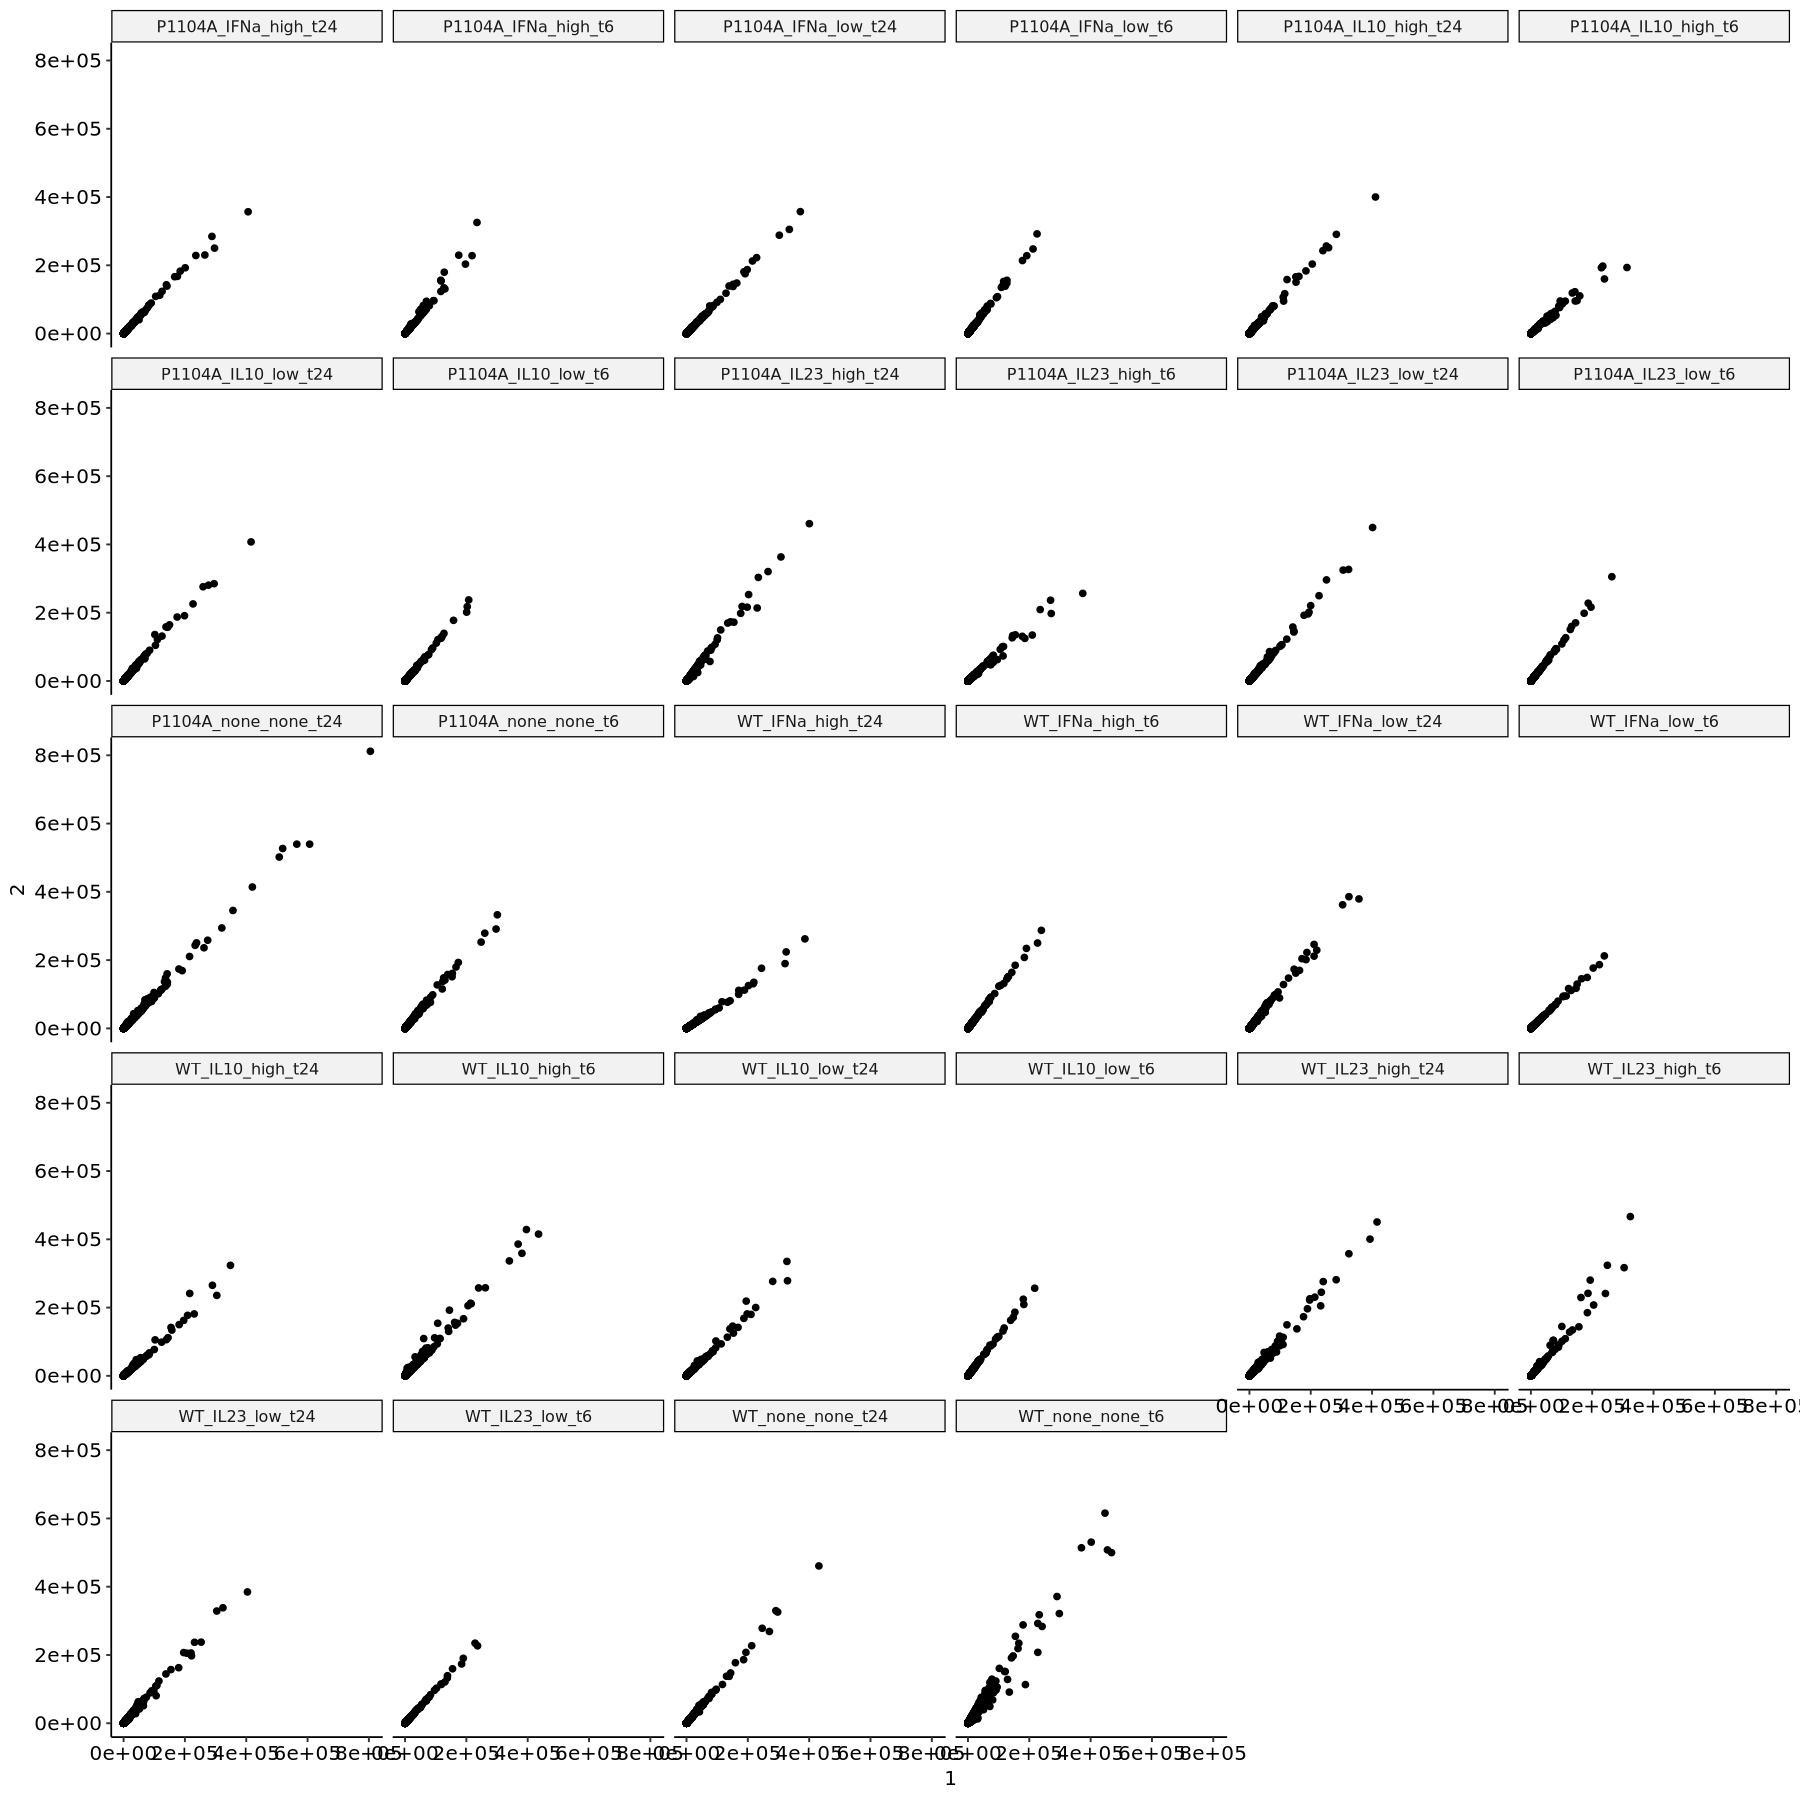

In [44]:
options(repr.plot.width = 15, repr.plot.height = 15)
count_matrix_thresh %>%
    pivot_wider(names_from = rep, values_from = count) %>%
    ggplot() +
        geom_point(aes(x = `1`, y = `2`)) +
        theme_pubr() +
        facet_wrap(~covariate)

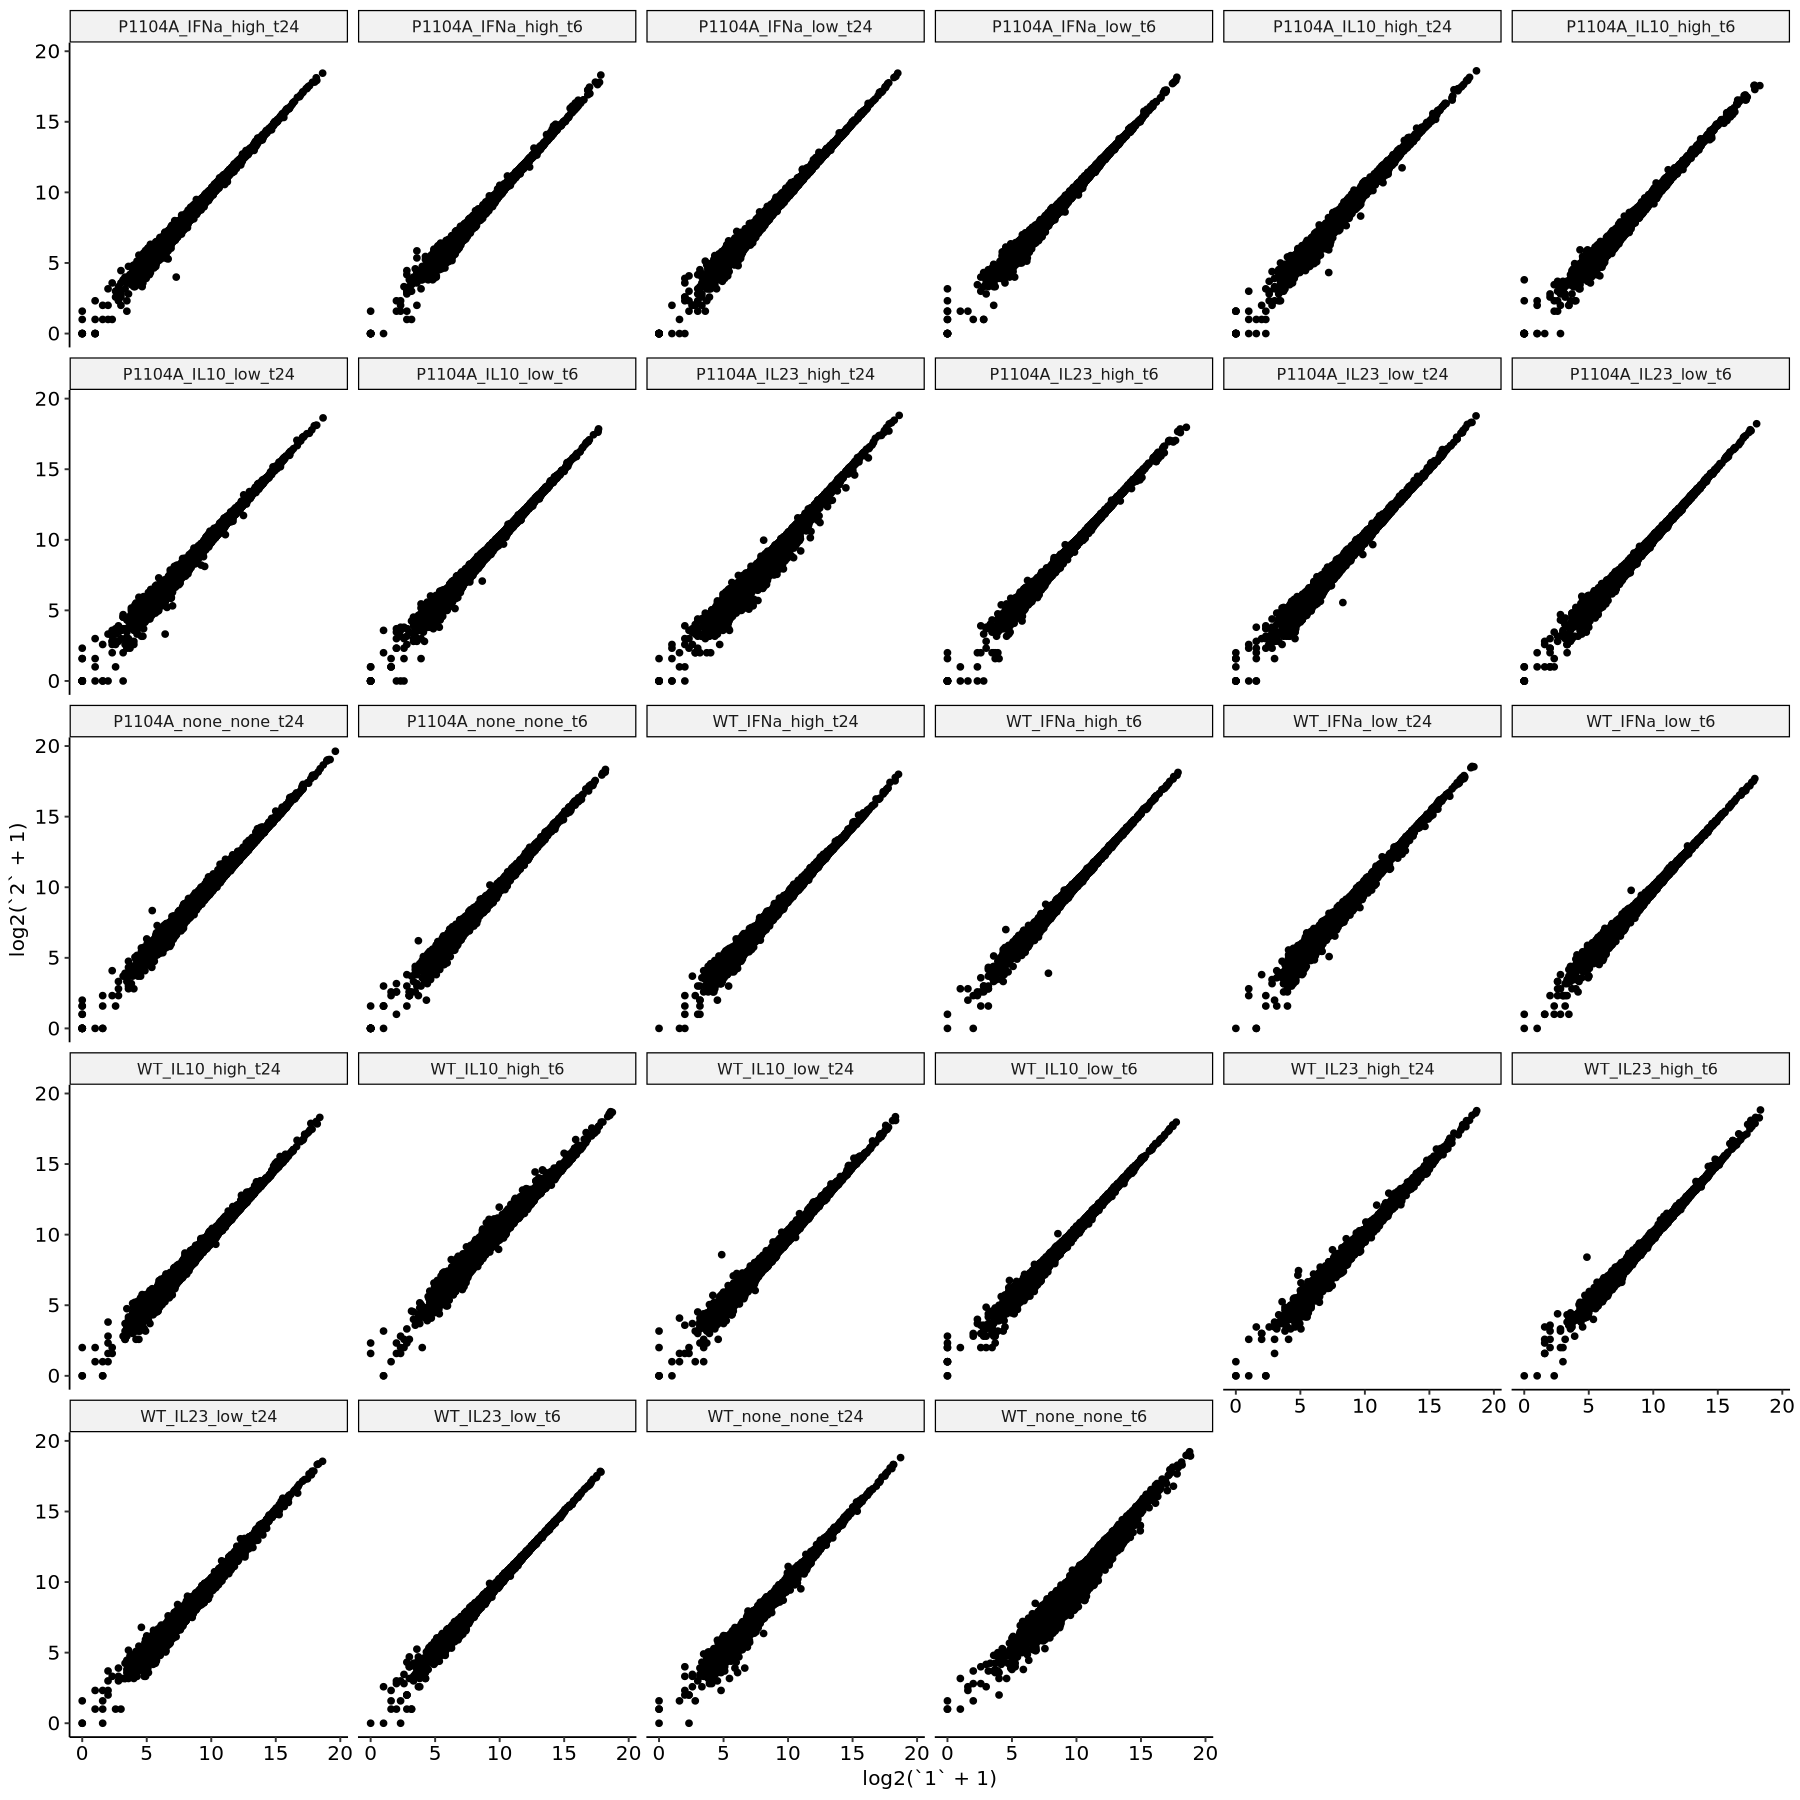

In [45]:
options(repr.plot.width = 15, repr.plot.height = 15)
count_matrix_thresh %>%
    pivot_wider(names_from = rep, values_from = count) %>%
    ggplot() +
        geom_point(aes(x = log2(`1`+1), y = log2(`2`+1))) +
        theme_pubr() +
        facet_wrap(~covariate)

In [134]:
count_matrix_wide <- count_matrix_thresh %>%
    mutate(count = log2(count+1)) %>%
    pivot_wider(names_from = covariate:rep, values_from = count)

cor_mat <- cor(count_matrix_wide[,-1], use = "pairwise.complete.obs")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


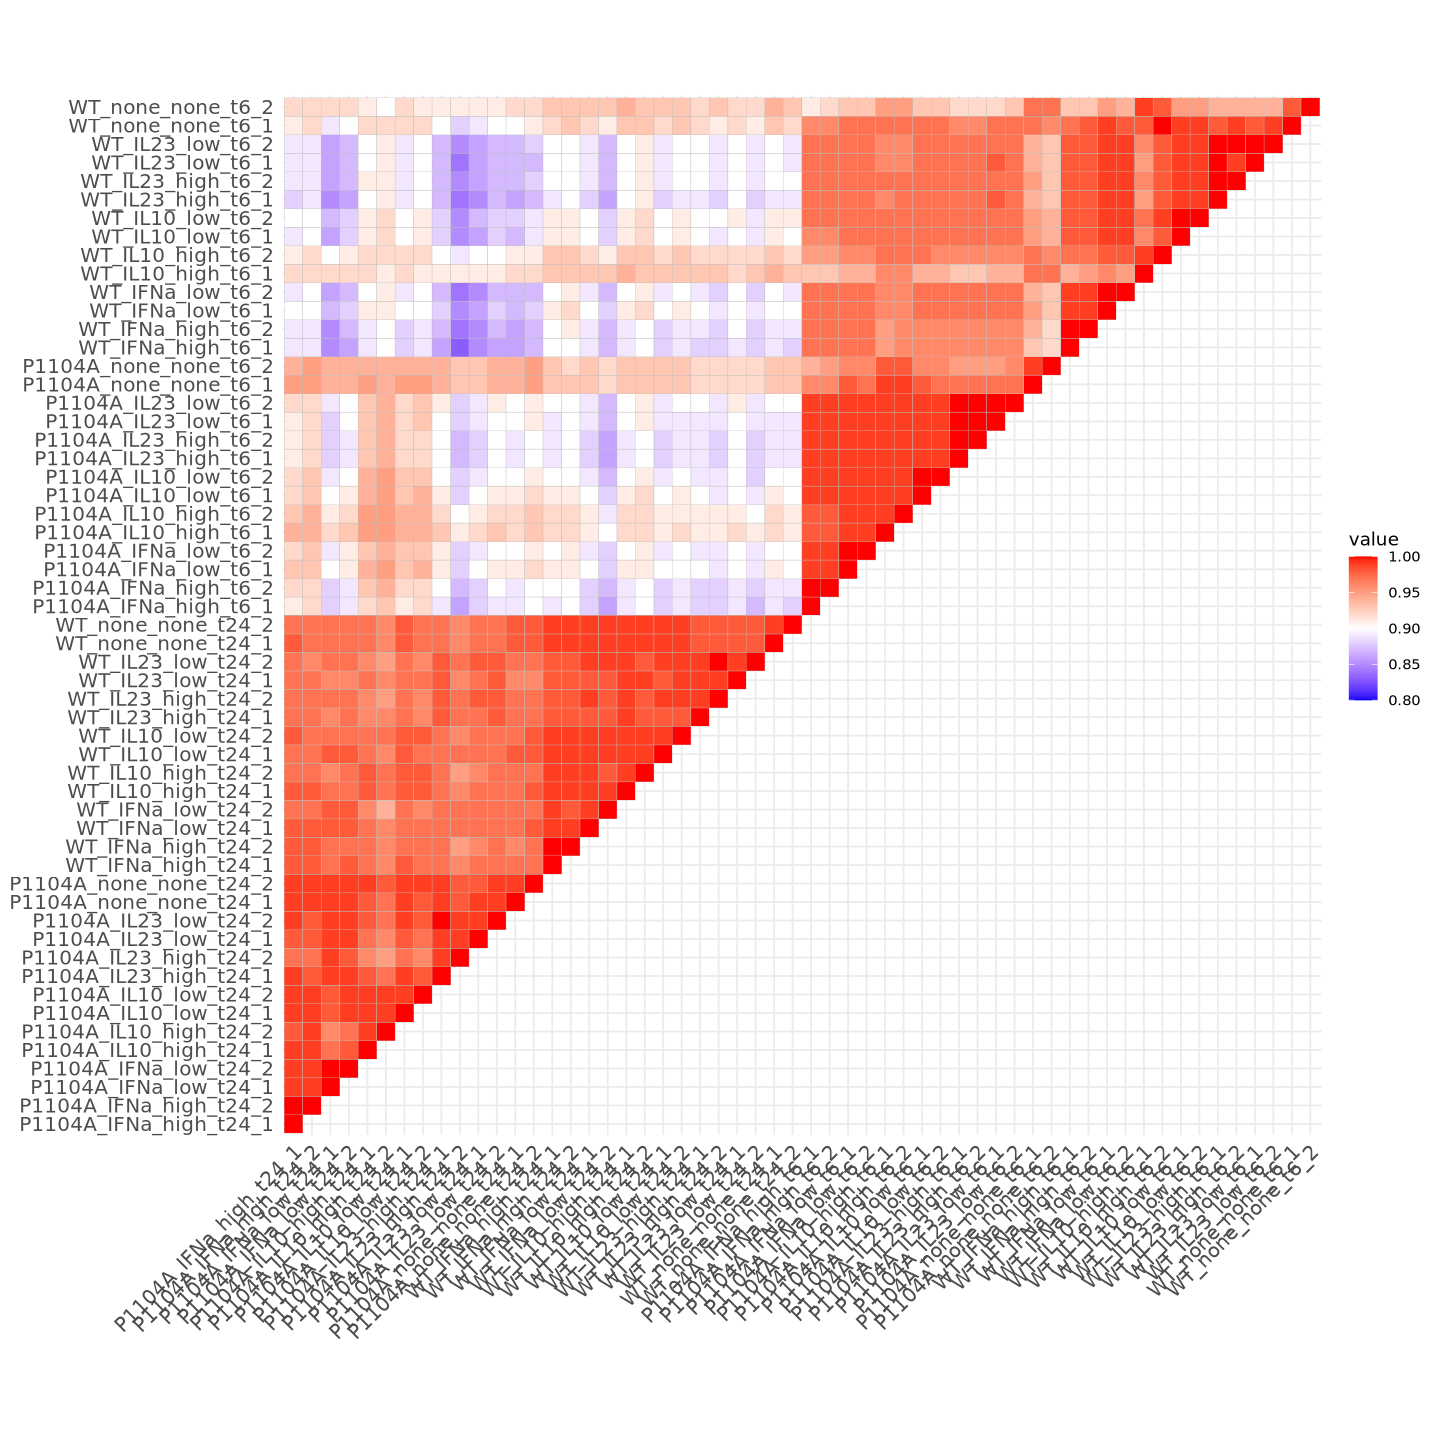

In [135]:
options(repr.plot.width = 12, repr.plot.height = 12)
ggcorrplot(cor_mat, hc.order = FALSE, type = "upper", show.diag = TRUE) +
    scale_fill_gradient2(limit = c(0.8,1), low = "blue", high =  "red", mid = "white", midpoint = 0.9)

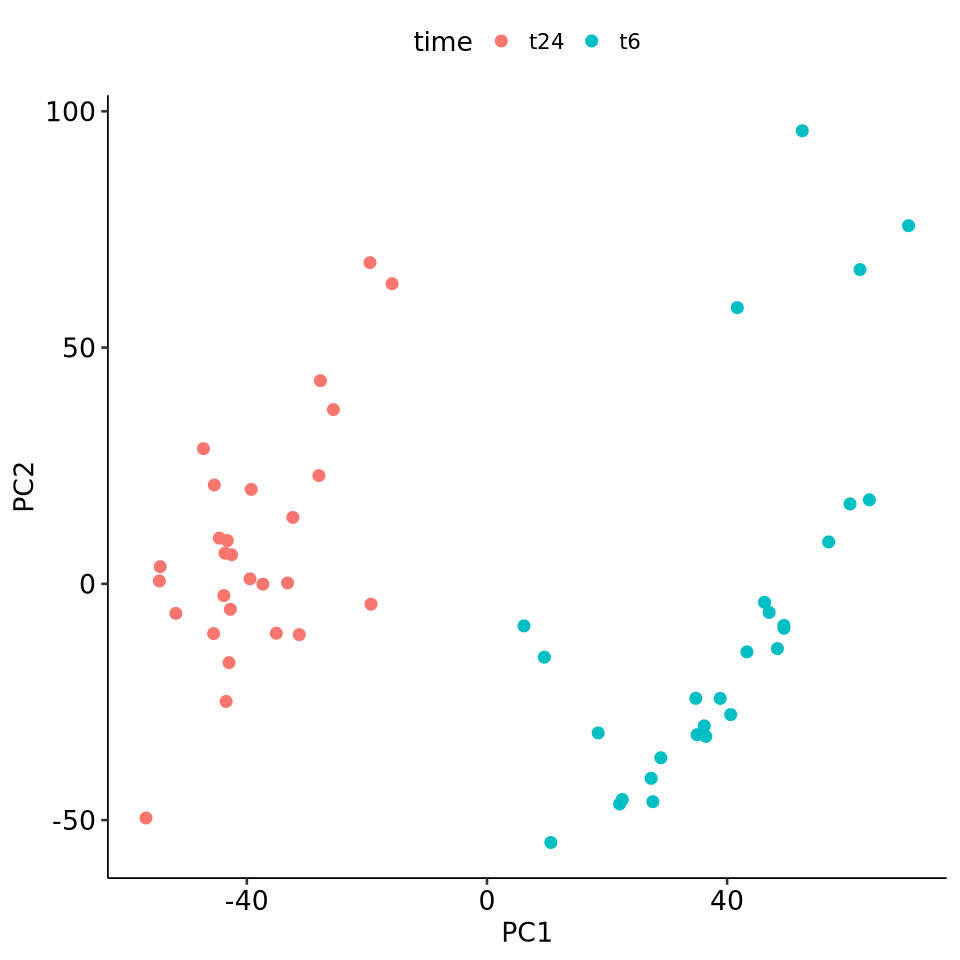

In [137]:
count_matrix_tr <- t(as.matrix(count_matrix_wide[,-1]))
pca_obj <- prcomp(count_matrix_tr)
pca_coords <- as_tibble(pca_obj$x) %>%
    mutate(sample = rownames(pca_obj$x)) %>%
    separate(sample, c("background", "cytokine", "dosage", "time", "rep"), "_")

options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(pca_coords) +
    geom_point(aes(x = PC1, y = PC2,
                   color = time), size = 3) +
    theme_pubr(base_size = 16)

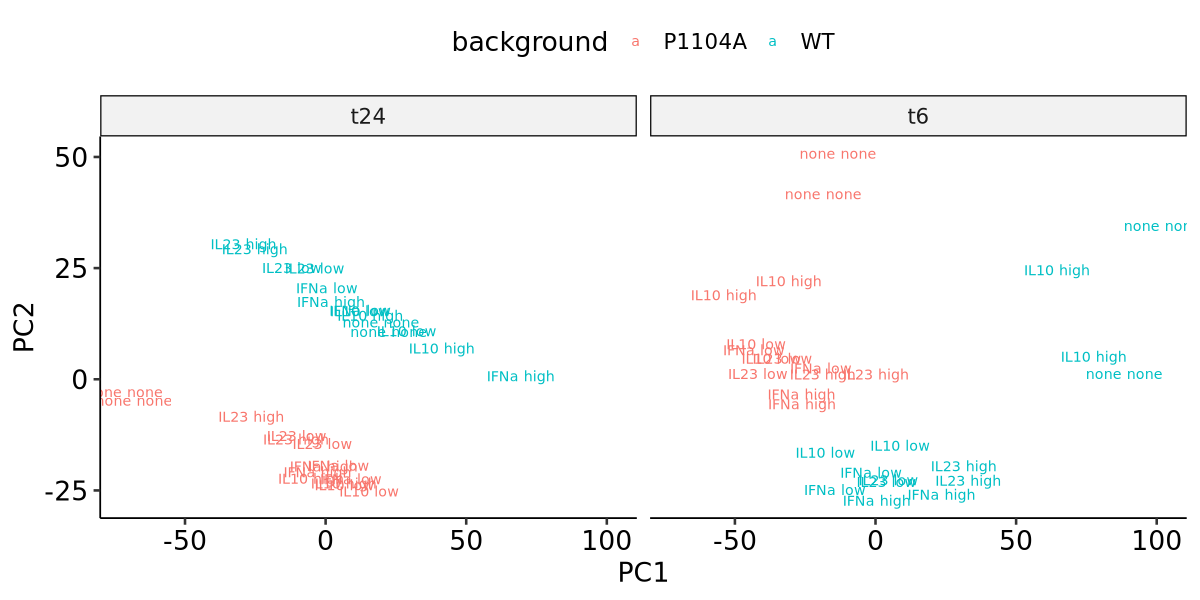

In [138]:
idx_t6 <- grepl("t6", rownames(count_matrix_tr))

pca_obj_t6 <- prcomp(count_matrix_tr[idx_t6,])
pca_obj_t24 <- prcomp(count_matrix_tr[!idx_t6,])

pca_coords_t6 <- as_tibble(pca_obj_t6$x) %>%
    mutate(sample = rownames(pca_obj_t6$x)) %>%
    separate(sample, c("background", "cytokine", "dosage", "time", "rep"), "_")

pca_coords_t24 <- as_tibble(pca_obj_t24$x) %>%
    mutate(sample = rownames(pca_obj_t24$x)) %>%
    separate(sample, c("background", "cytokine", "dosage", "time", "rep"), "_")

pca_coords_dual <- bind_rows(pca_coords_t6,
                             pca_coords_t24)

options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(pca_coords_dual) +
    geom_text(aes(x = PC1, y = PC2,
                  color = background,
                  label = str_c(cytokine, " ", dosage)),
              size = 3) +
    theme_pubr(base_size = 16) +
    facet_wrap(~time)

#### Statistical Modeling <a name="part3"></a>

In [47]:
de_prop <- samp_prop %>%
    filter(!is.na(cytokine)) %>%
    arrange(covariate)
rownames(de_prop) <- str_c(de_prop$covariate, "_", de_prop$rep)

de_data <- df_id %>%
    inner_join(de_prop %>% select(sample_id, covariate, rep), by = c("id" = "sample_id")) %>%
    select(-id) %>%
    filter(!is.na(covariate)) %>%
    arrange(covariate, rep) %>%
    pivot_wider(names_from = covariate:rep, values_from = count)

log2_cpm <- de_data %>%
    pivot_longer(names_to = "sample", values_to = "count", -gene) %>%
    group_by(sample) %>%
    mutate(count = log2(count * 1000000 / sum(count, na.rm = TRUE)),
           count = if_else(is.infinite(count), NA, count)) %>%
    pivot_wider(names_from = sample, values_from = count)

write_tsv(de_data, "../sumstats/RNASEQ/run2/combined/raw-counts.tsv")
write_tsv(log2_cpm, "../sumstats/RNASEQ/run2/combined/log2-cpm.tsv")

Warning message:
“Setting row names on a tibble is deprecated.”


In [48]:
deobj_counts <- DESeqDataSetFromMatrix(countData = de_data %>% select(-gene),
    colData = de_prop,
    design = ~covariate)

deresult <- DESeq(deobj_counts)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [49]:
cov_group <- de_prop %>%
    filter(!grepl("none", covariate)) %>%
    distinct(covariate) %>%
    pull(covariate) %>%
    as.character()

none_group <- gsub("IFNa|IL10|IL23|low|high", "none", cov_group) %>%
    as.character()

plan(multicore, workers = 25)
norm_result <- future_map2(.x = cov_group,
                    .y = none_group,
                    ~results(deresult,
                             contrast = c("covariate", .x, .y),
                             independentFiltering = FALSE))

sumstats <- map2_dfr(norm_result,
                     cov_group,
                     ~bind_cols("gene" = de_data$gene,
                                            as_tibble(.x),
                                            "condition" = .y))

sumstats %>%
    separate(condition, c("background", "cytokine", "dosage", "time"), "_") %>%
    write_tsv("../sumstats/RNASEQ/run2/combined/deseq2-sumstats-vs-none.tsv")

Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

In [52]:
sumstats <- read_tsv( "../sumstats/RNASEQ/run2/combined/deseq2-sumstats-vs-none.tsv.gz")
split_sumstats <- sumstats %>%
    mutate(group = case_when(padj == 1 ~ "FDR = 1",
                             padj < 0.01 ~ "FDR < 0.01",
                             TRUE ~ "NS")) %>%
    mutate(time = relevel(as.factor(time), ref = "t6"),
           dosage = relevel(as.factor(dosage), ref = "low"))

ma_grid <- split_sumstats %>%
    ggplot() +
        geom_point(aes(x = log2(baseMean),
                       y = log2FoldChange,
                       color = group)) +
        theme_pubr(base_size = 15) +
        facet_grid(rows = vars(dosage, time),
                   cols = vars(cytokine, background)) +
        scale_color_manual(values = c("FDR = 1" = "gray",
                                      "NS" = "black",
                                      "FDR < 0.01" = "red"))

Rows: 1454568 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene, background, cytokine, dosage, time
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


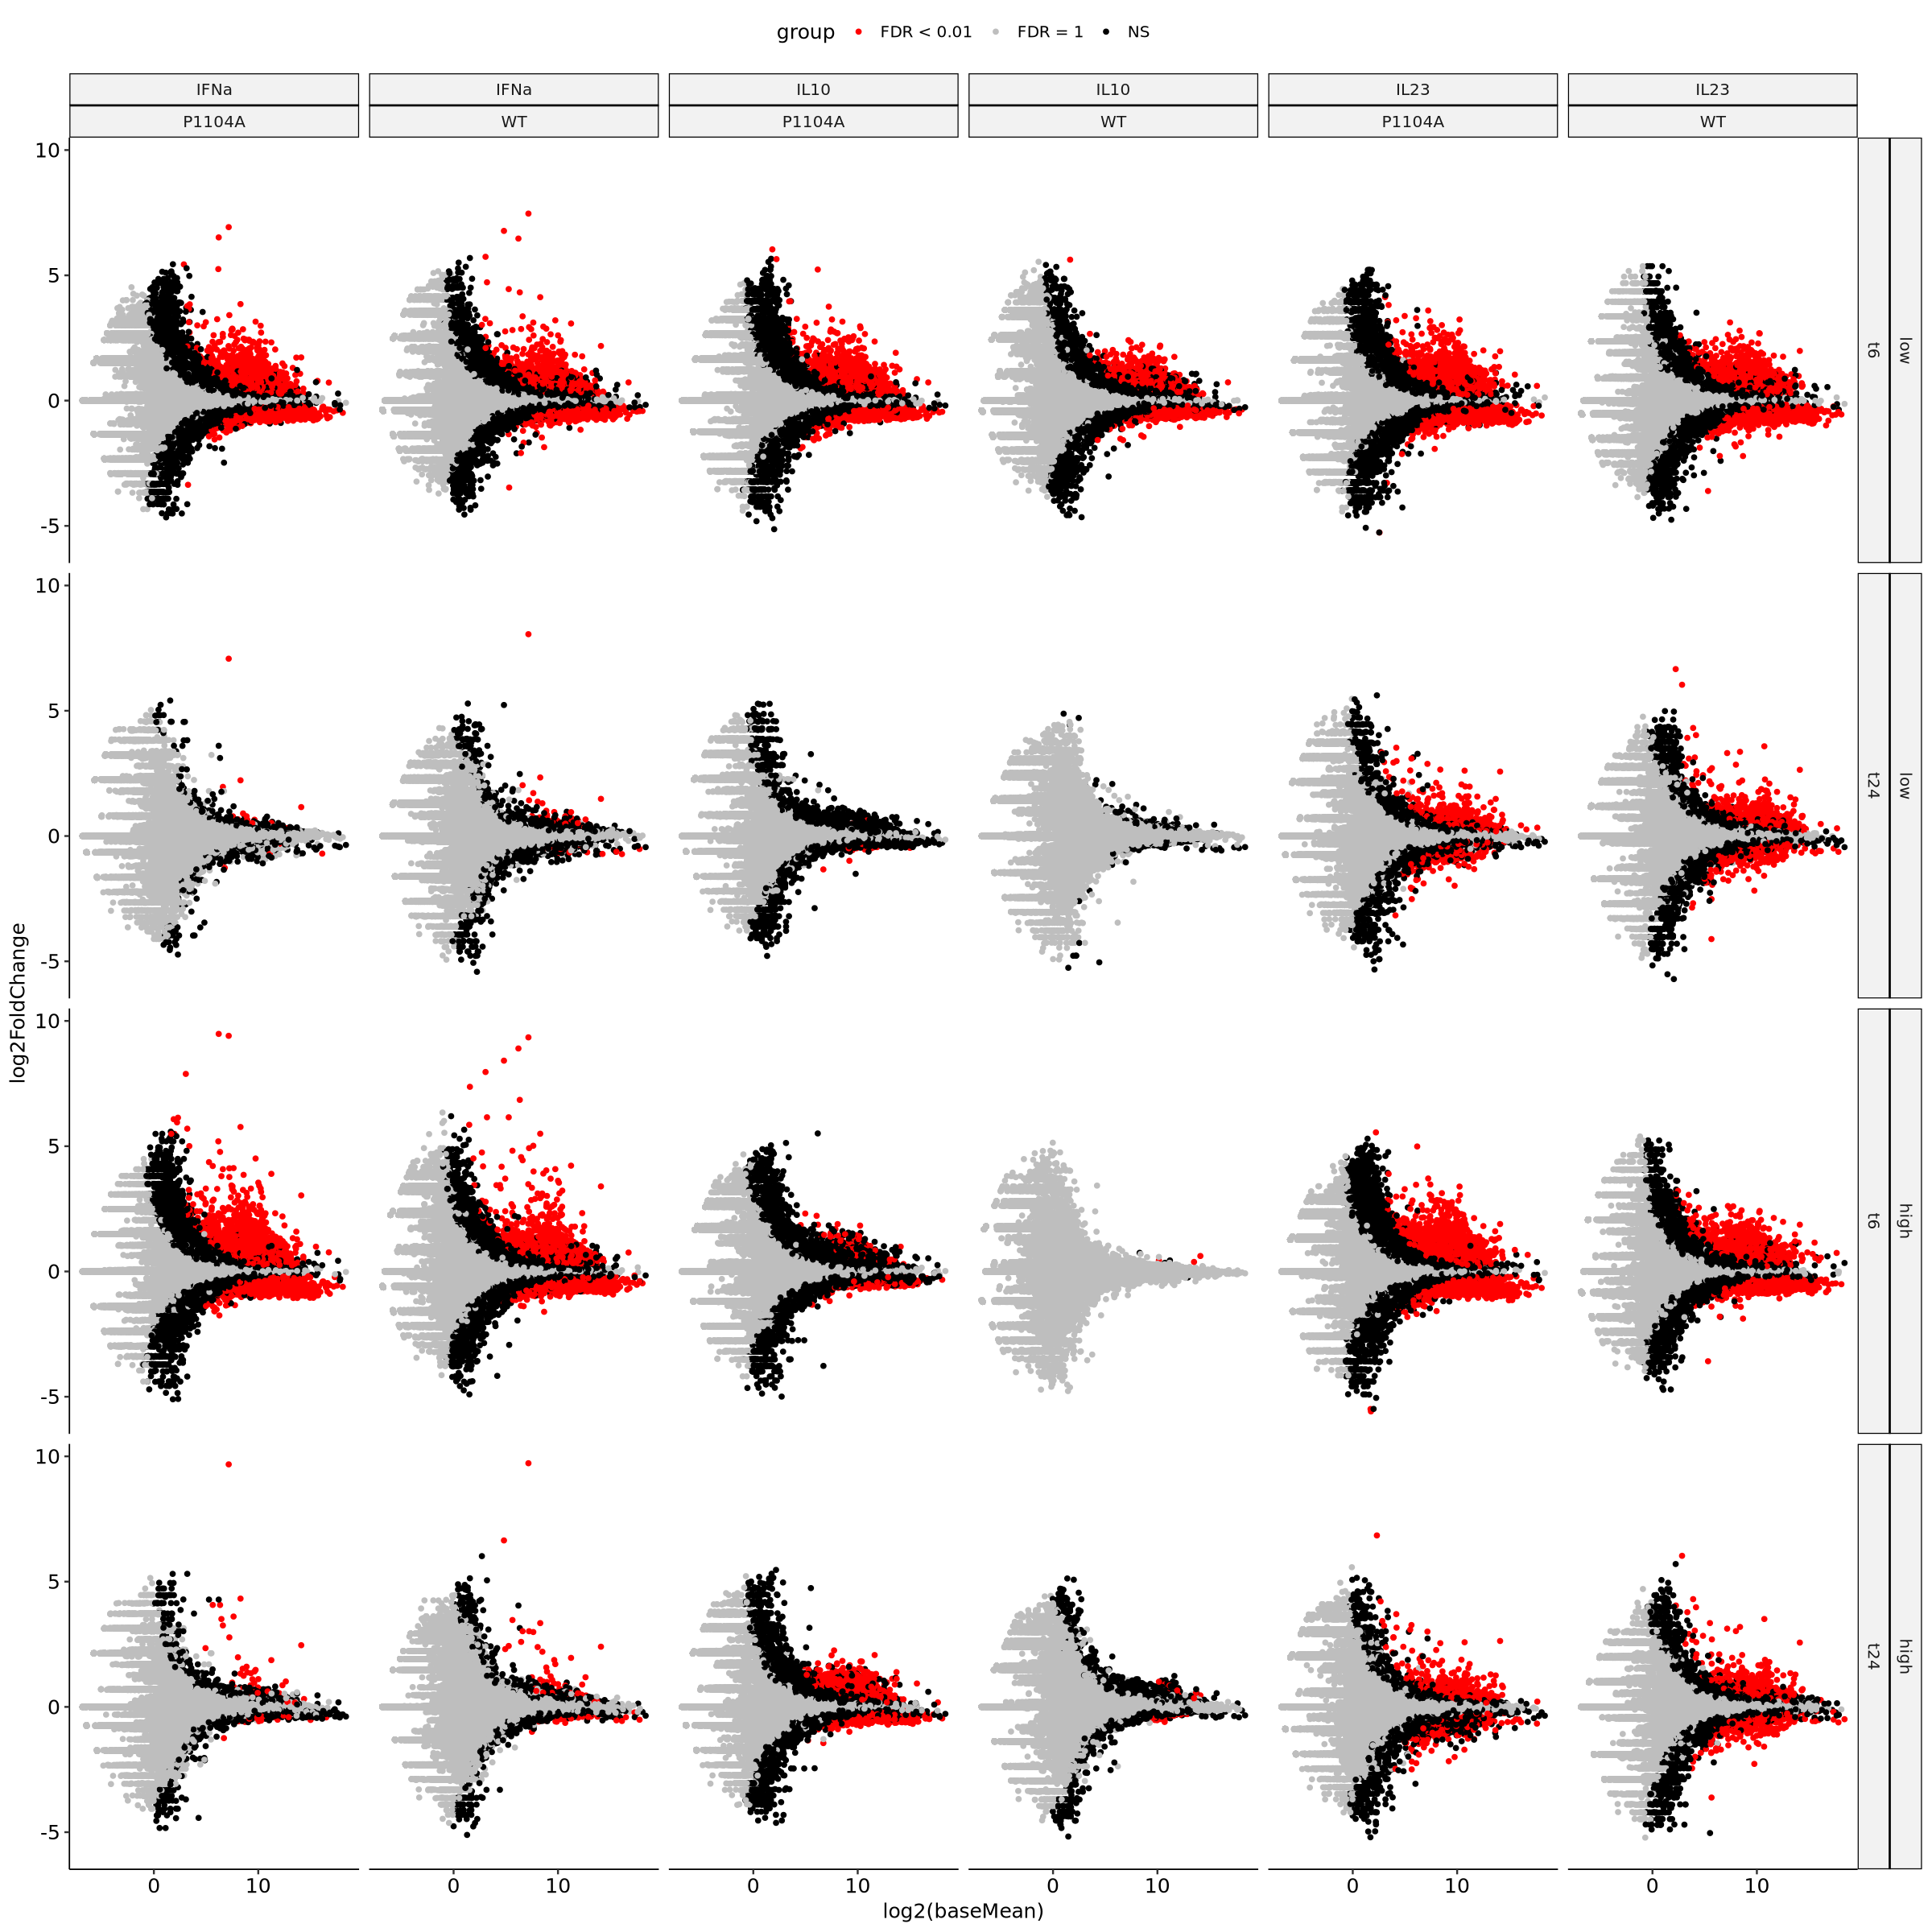

In [53]:
options(repr.plot.width = 20, repr.plot.height = 20, warn = -1)
ma_grid

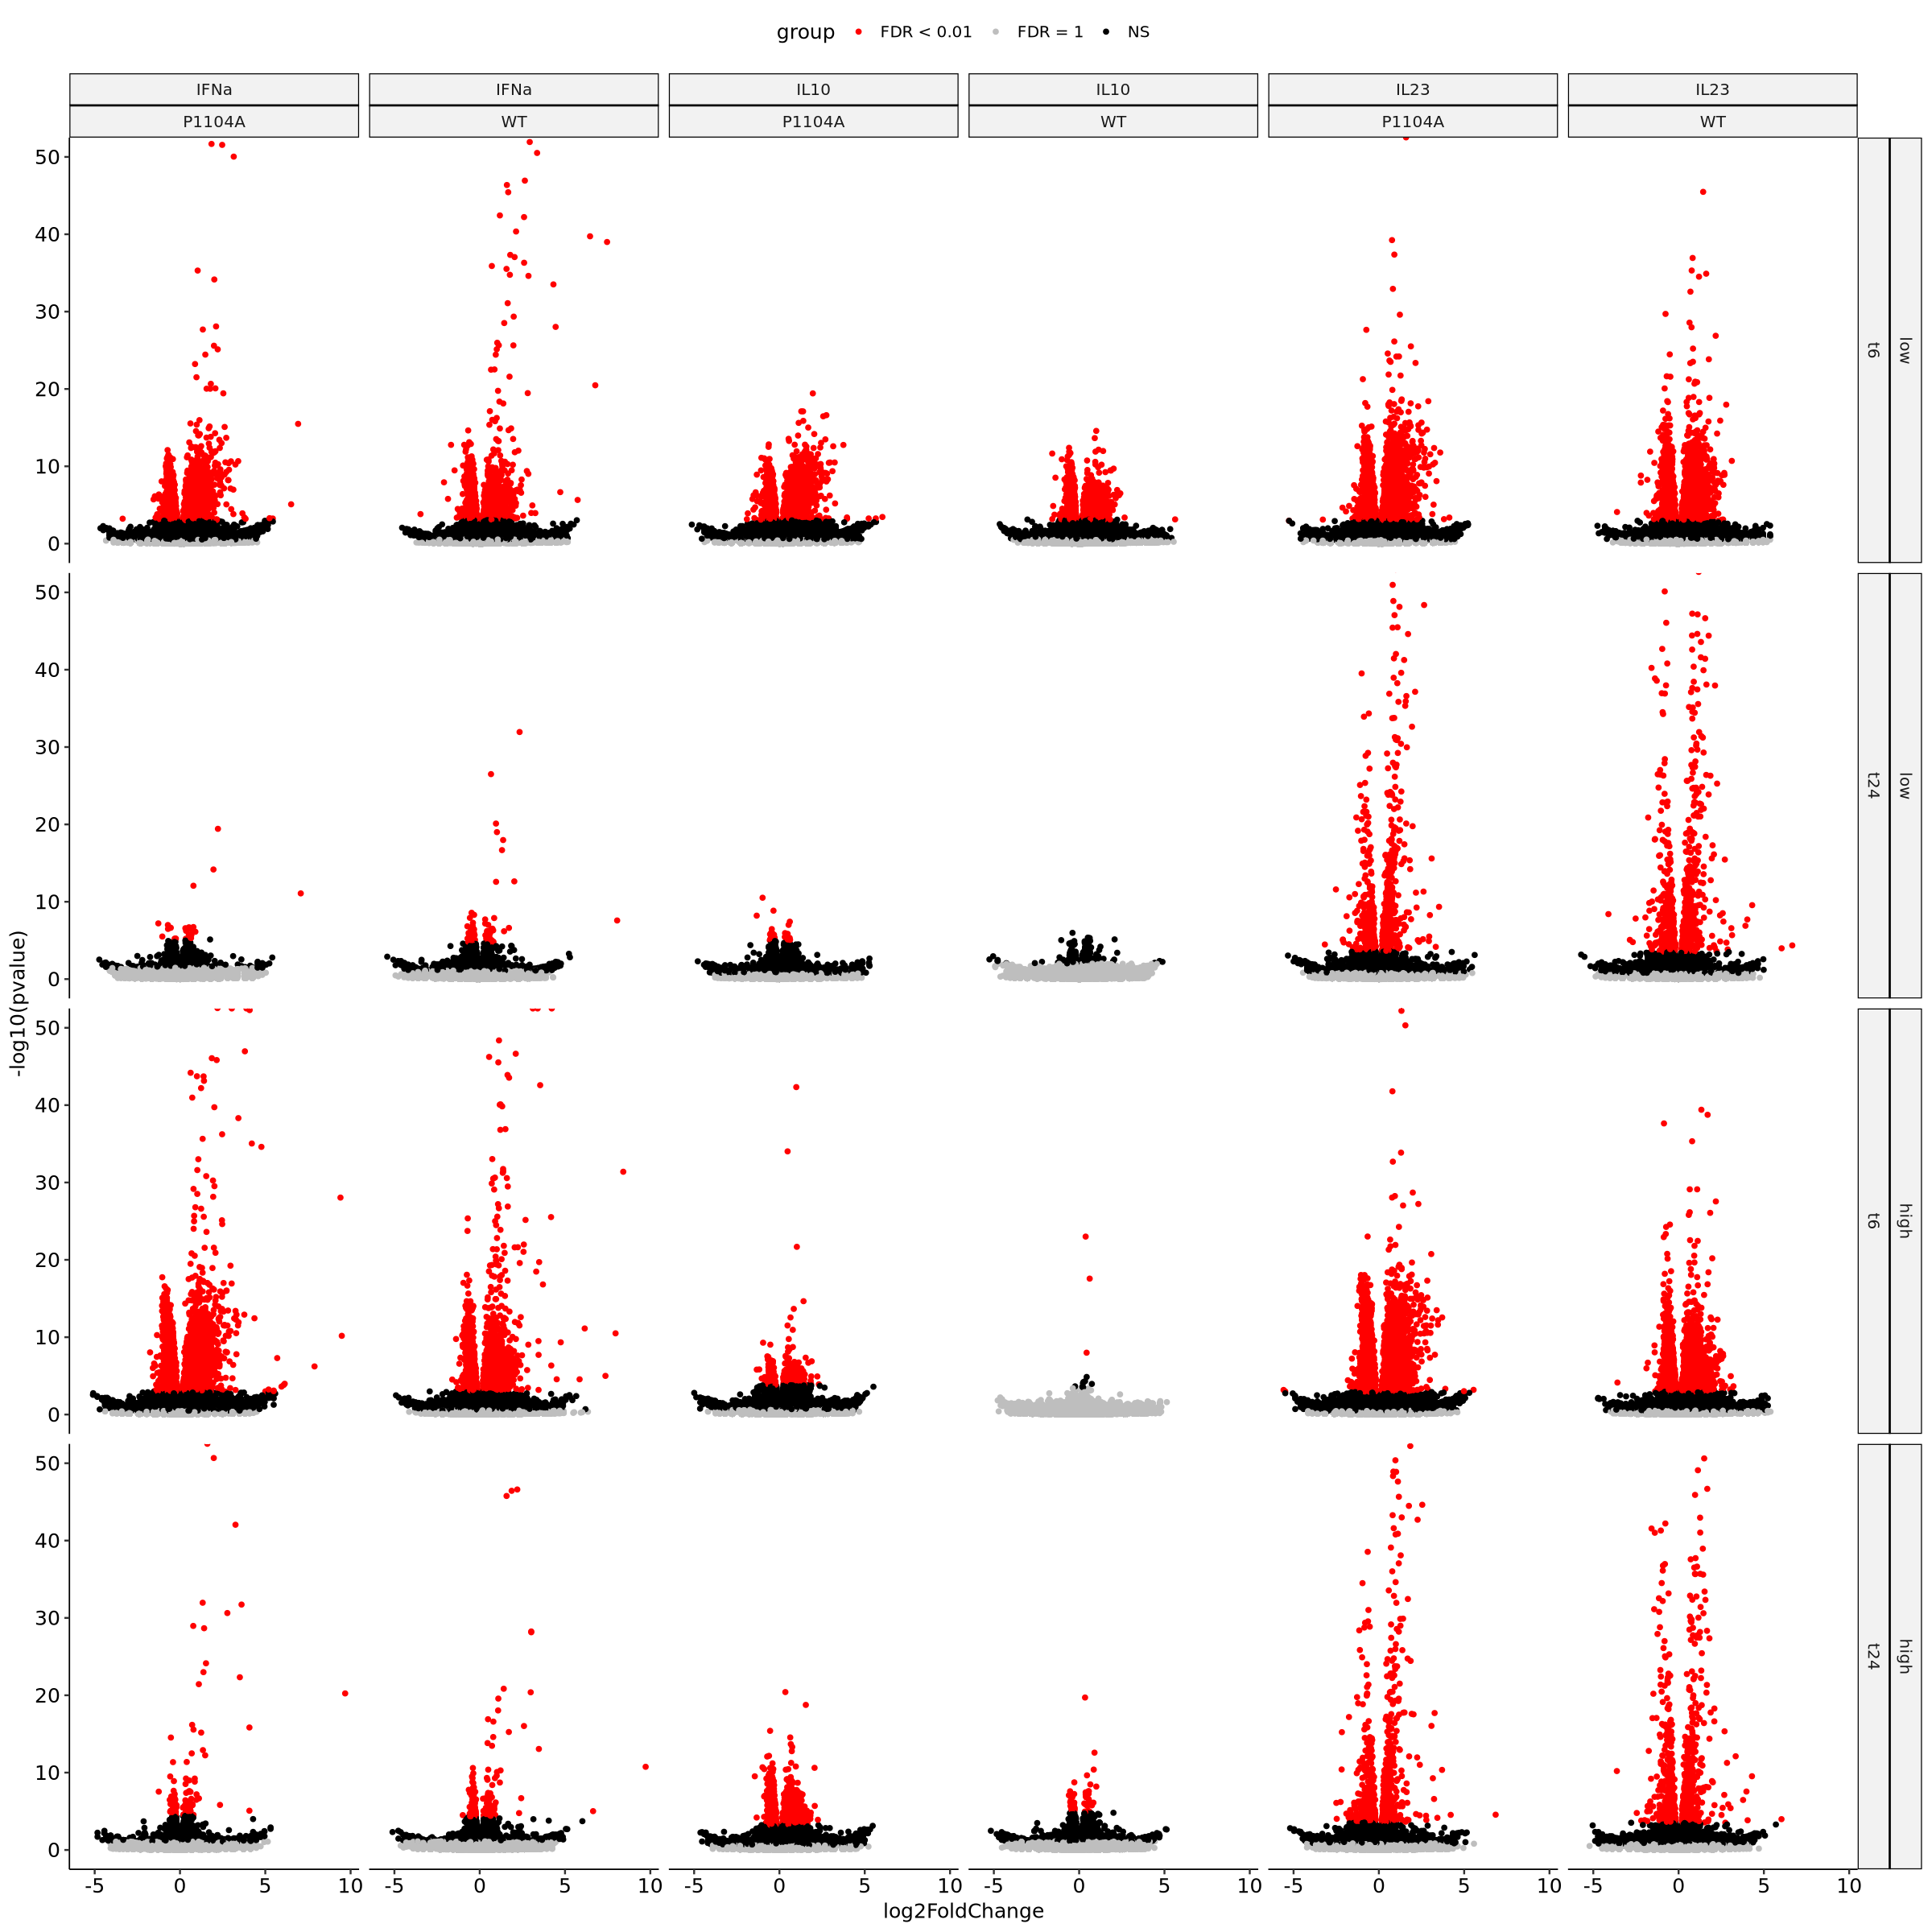

In [54]:
volcano_grid <- split_sumstats %>%
    ggplot() +
        geom_point(aes(x = log2FoldChange,
                       y = -log10(pvalue),
                       color = group)) +
        theme_pubr(base_size = 15) +
        facet_grid(rows = vars(dosage, time),
                   cols = vars(cytokine, background)) +
        scale_color_manual(values = c("FDR = 1" = "gray",
                                      "NS" = "black",
                                      "FDR < 0.01" = "red")) +
        coord_cartesian(ylim = c(0, 50))

options(repr.plot.width = 20, repr.plot.height = 20, warn = -1)
volcano_grid

In [148]:
sumstats_marg_dose <- sumstats %>%
    filter(time == "t6") %>%
    select(gene, log2FoldChange, lfcSE, background, cytokine, dosage) %>%
    pivot_wider(names_from = dosage, values_from = log2FoldChange:lfcSE) %>%
    drop_na() %>%
    mutate(effect = (log2FoldChange_high + log2FoldChange_low)/2,
           error = sqrt(lfcSE_high^2 + lfcSE_low^2),
           stat = effect/error) %>%
    select(gene, background, cytokine, effect, error, stat)

In [157]:
sumstats_marg_dose_wide <- sumstats_marg_dose %>%
    select(-effect, -error) %>%
    pivot_wider(names_from = background:cytokine, values_from = stat) %>%
    arrange(-WT_IFNa)

sumstats_marg_dose_wide %>% head(10)

gene   P1104A_IFNa P1104A_IL10 P1104A_IL23 WT_IFNa  WT_IL10    WT_IL23   
1  STAT1  23.599133    5.01561536 19.14449444 27.98012  2.7249167 19.2985085
2  OAS2   21.856462    2.08089756  2.26733494 26.68315  0.9163157  2.1712295
3  PARP9  16.032478    2.51016469 11.44241518 22.57178  1.8807420 12.0084712
4  OAS1   14.887134   -0.48186751 -0.21105494 22.18690 -0.4086254 -0.2835280
5  EPSTI1 14.817647   -0.11348439  0.78074351 22.13383  1.0934202  1.7674827
6  SLFN5  13.927253    1.81420980  2.34521737 17.80204  1.2544153  1.9709722
7  HERC5   9.090210   -0.63184119 -0.02765965 17.74987  0.7318314  0.2346673
8  CMPK2  11.758464   -1.40688100 -1.26991568 16.97115 -0.4629770  0.3230340
9  EHD4    8.758219    1.75091307  3.73227426 14.98585  2.1011319  2.9903967
10 RSAD2  10.091023    0.09748118 -0.35989935 14.71690 -0.2909626  0.2465795

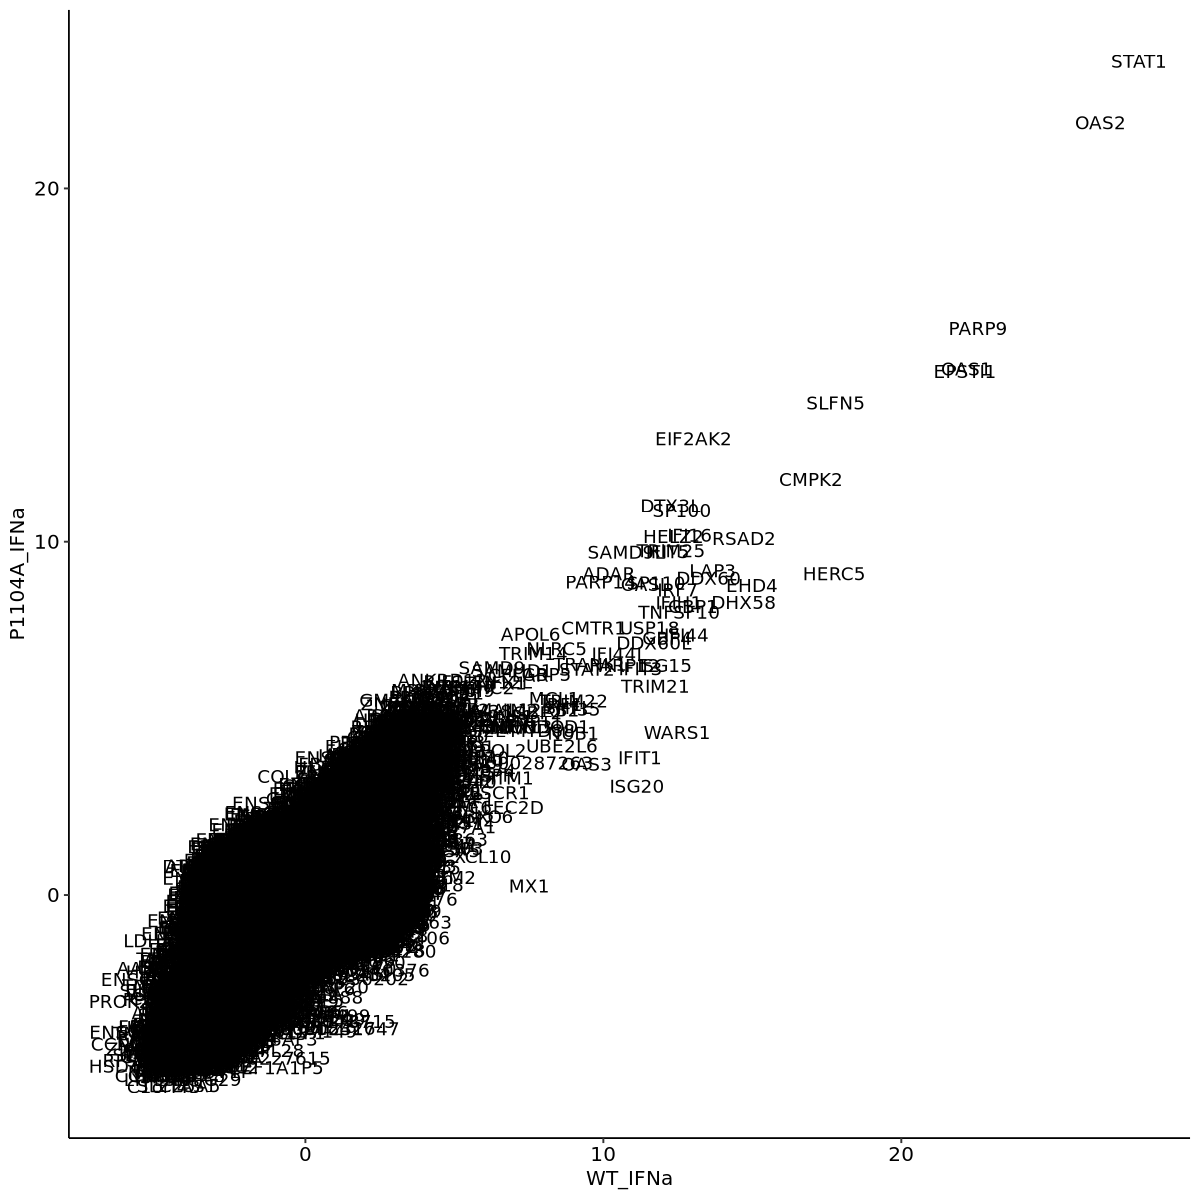

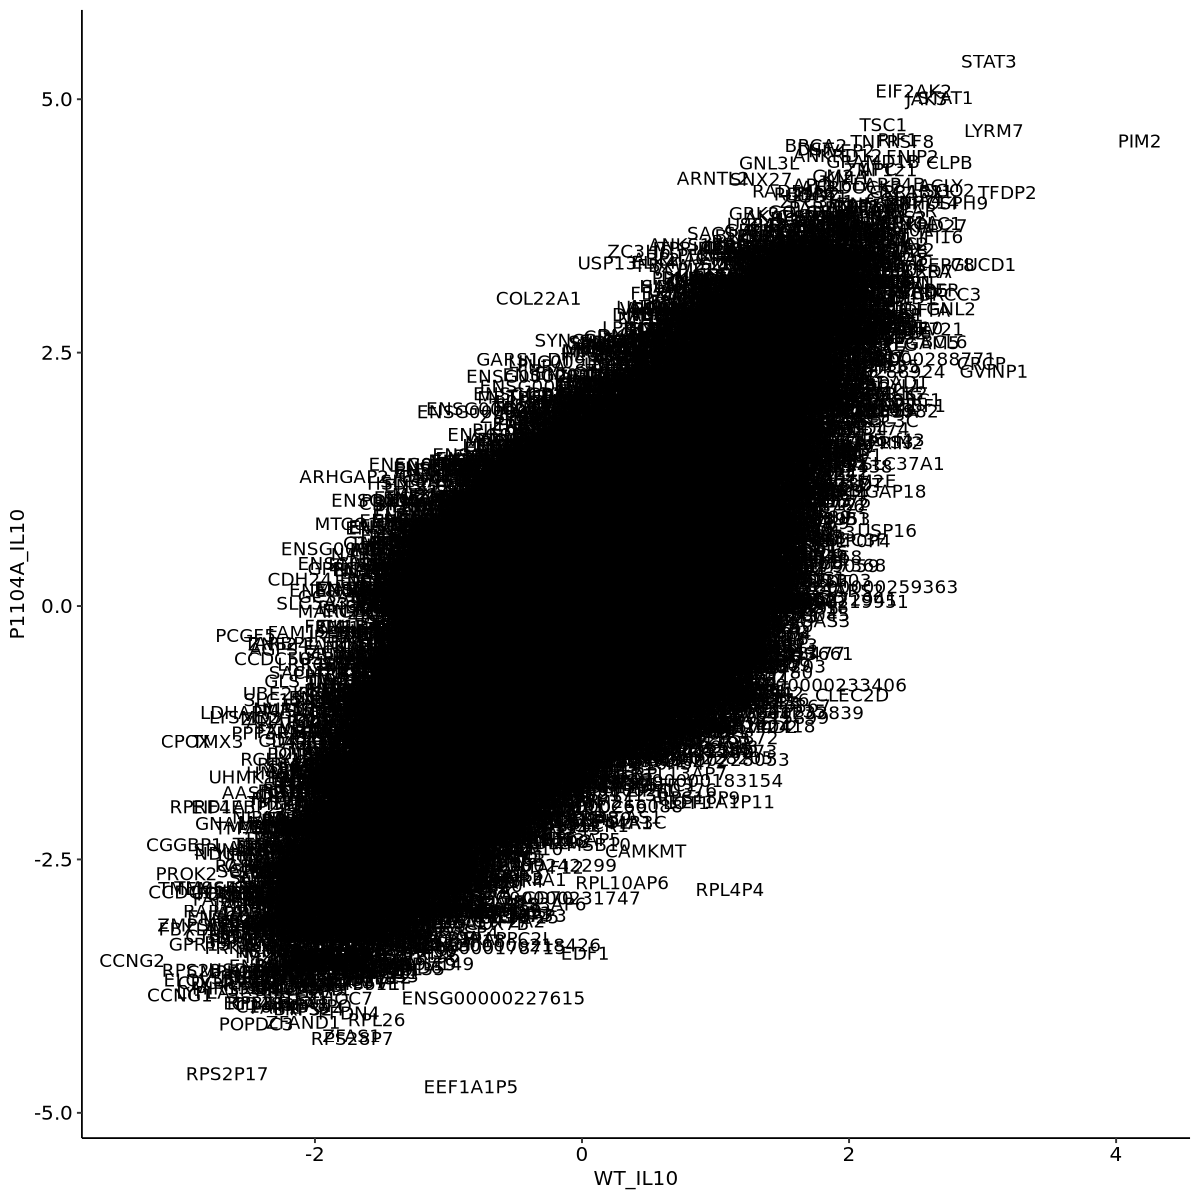

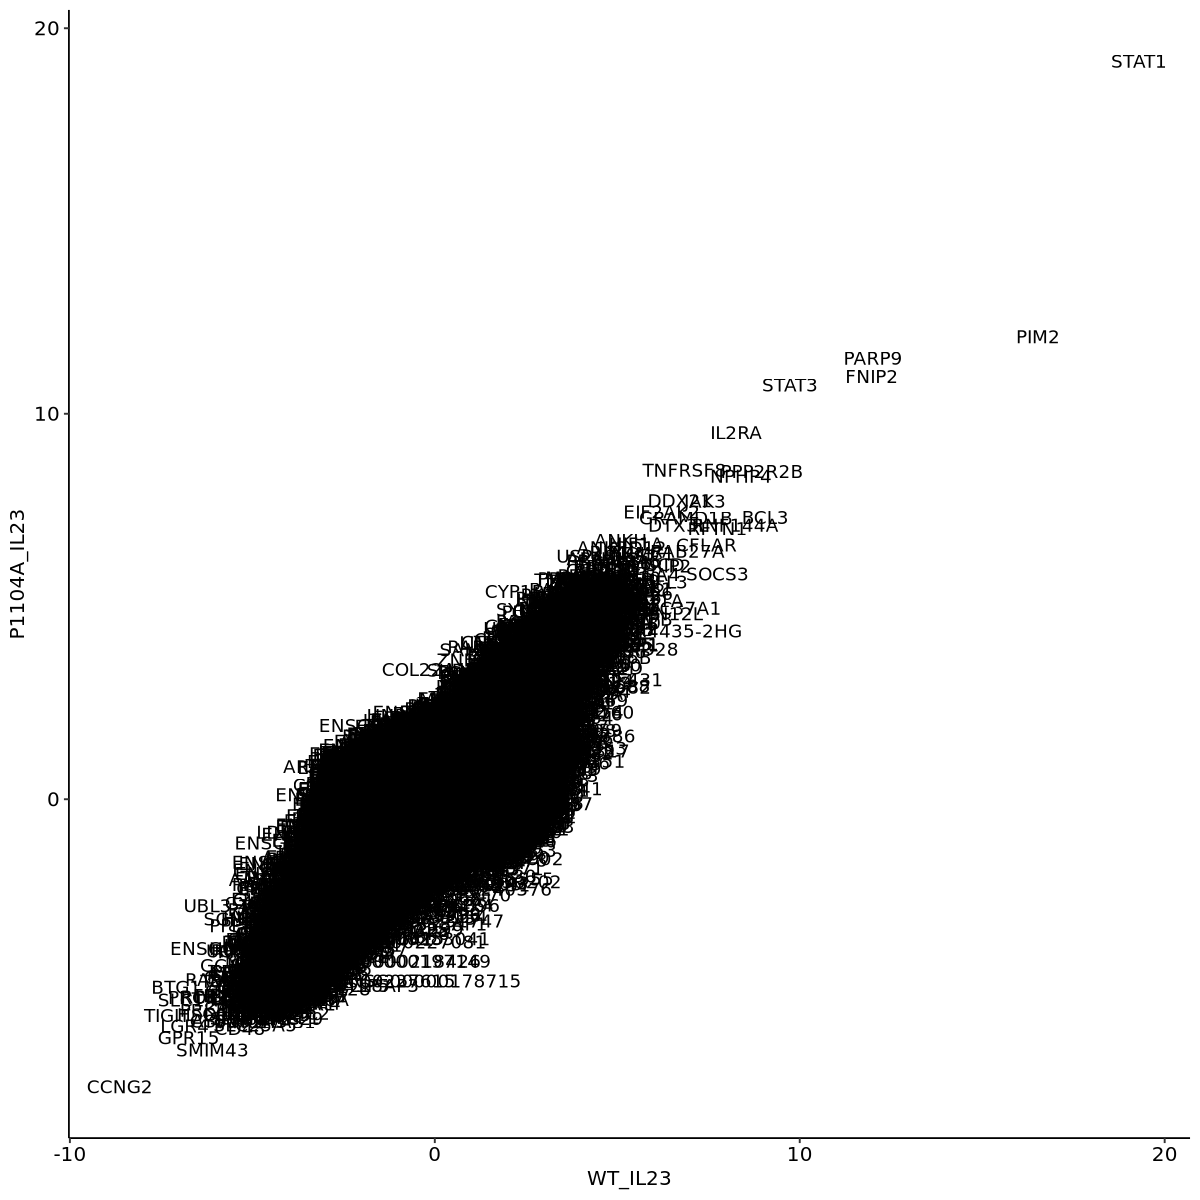

In [162]:
options(repr.plot.width = 10, repr.plot.height = 10)
sumstats_marg_dose_wide %>%
    ggplot() +
        geom_text(aes(x = WT_IFNa, y = P1104A_IFNa, label = gene)) +
        theme_pubr()

sumstats_marg_dose_wide %>%
    ggplot() +
        geom_text(aes(x = WT_IL10, y = P1104A_IL10, label = gene)) +
        theme_pubr()

sumstats_marg_dose_wide %>%
    ggplot() +
        geom_text(aes(x = WT_IL23, y = P1104A_IL23, label = gene)) +
        theme_pubr()

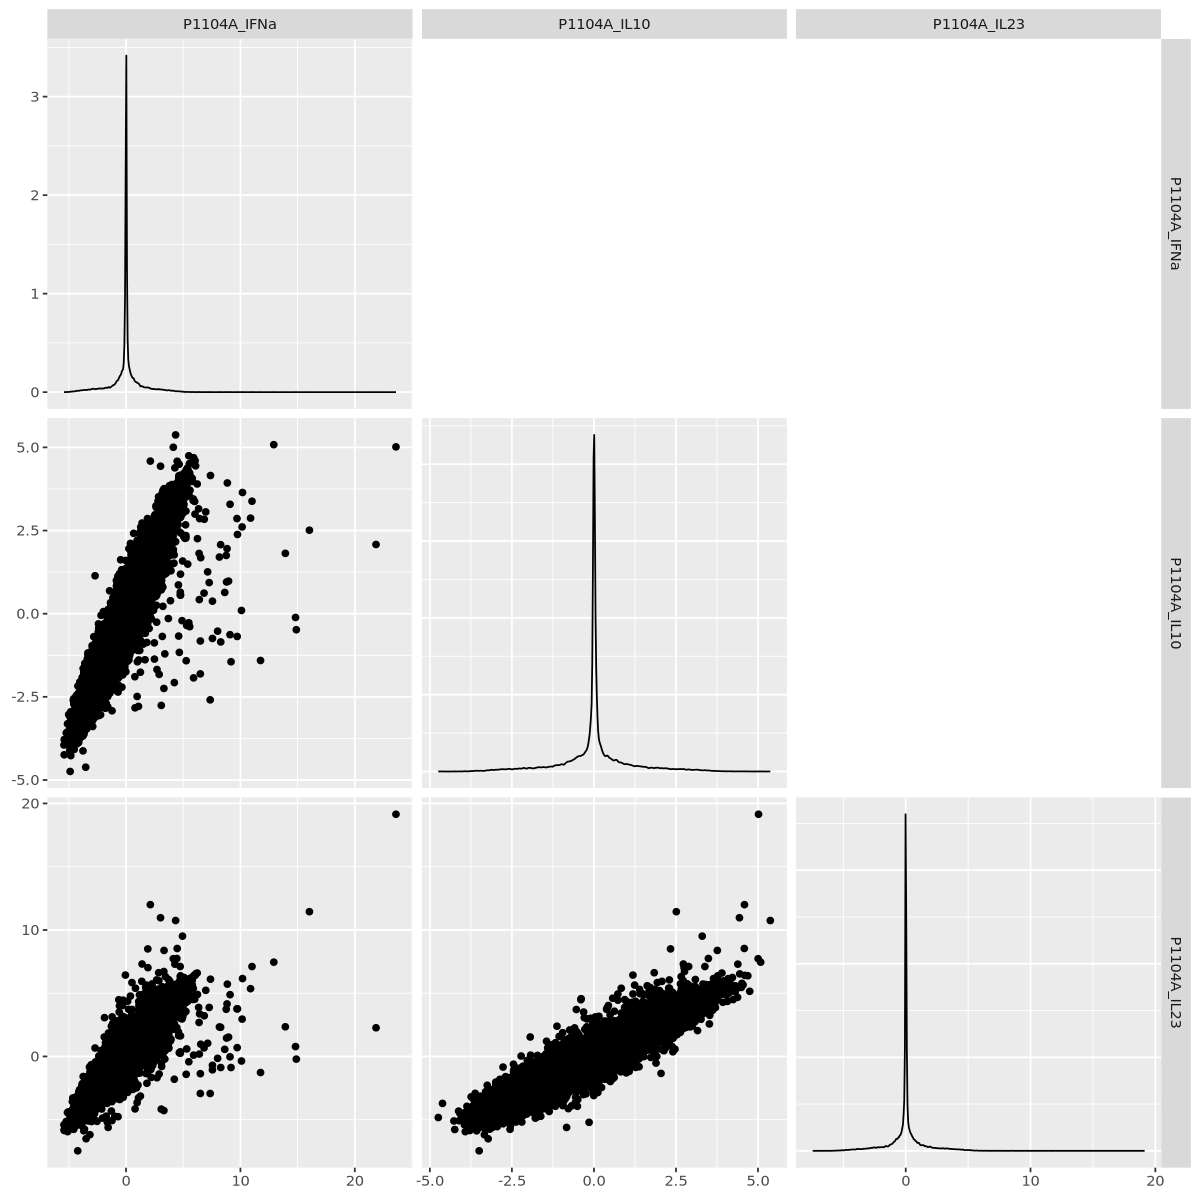

In [171]:
ggpairs(sumstats_marg_dose_wide[,2:4], upper = NULL)

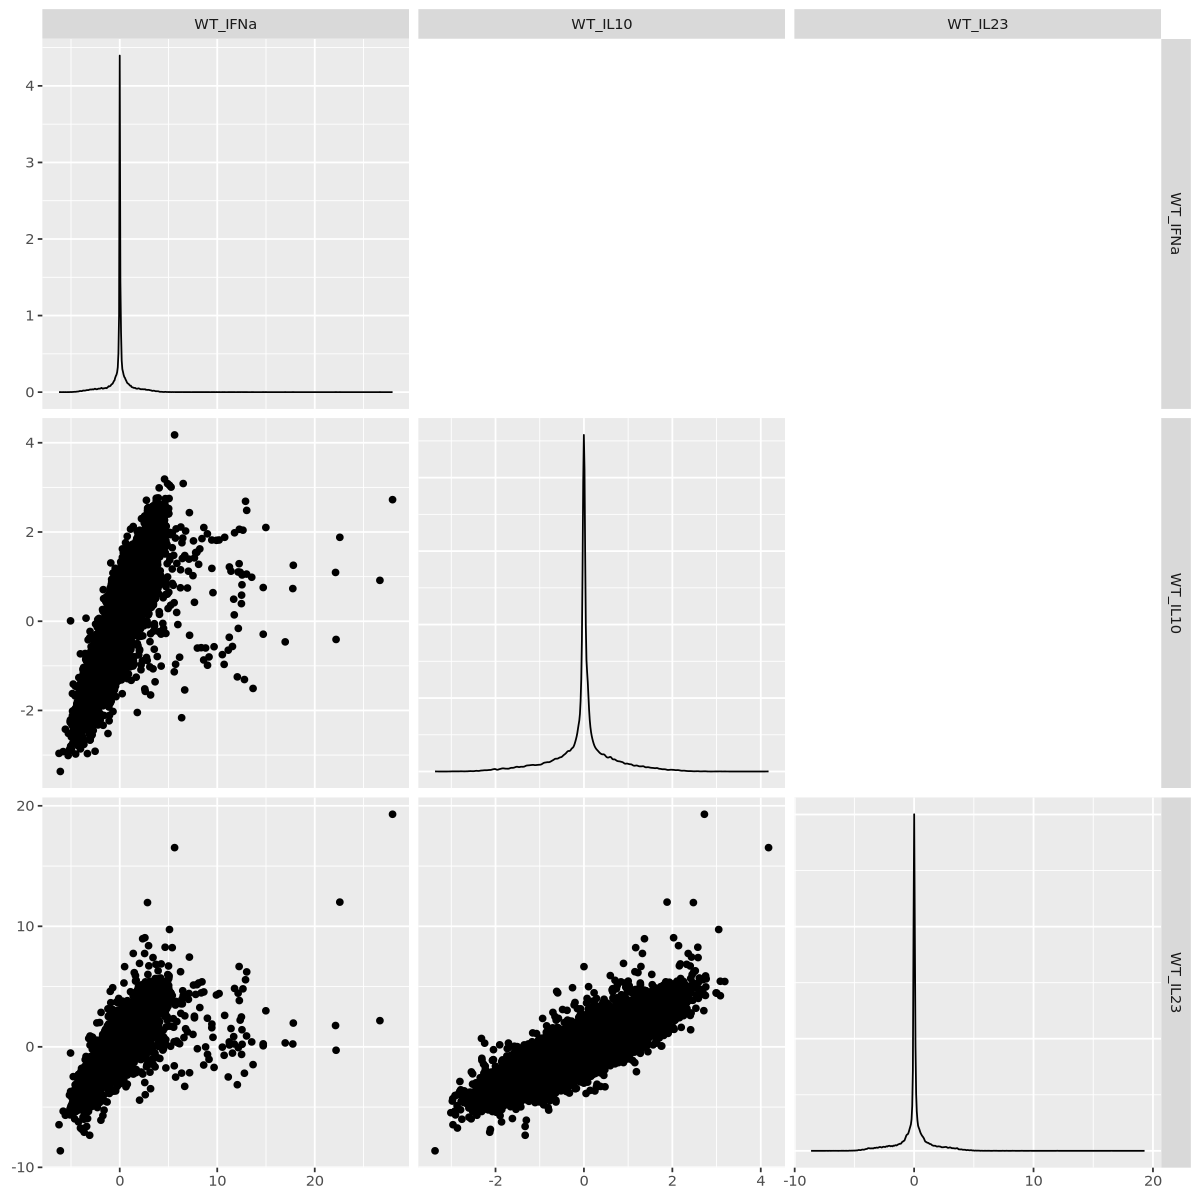

In [170]:
ggpairs(sumstats_marg_dose_wide[,5:7], upper = NULL)

In [175]:
sumstats_marg_dose_wide %>%
    arrange(-WT_IL10) %>%
    head(10)

gene   P1104A_IFNa P1104A_IL10 P1104A_IL23 WT_IFNa  WT_IL10  WT_IL23  
1  PIM2   2.124315    4.587469    11.998500   5.625667 4.176378 16.529604
2  TFDP2  5.667282    4.078956     5.315371   4.595962 3.186488  5.421322
3  GVINP1 5.050956    2.315285     3.412359   6.509803 3.086291  4.240134
4  LYRM7  5.907984    4.688827     6.377483   4.905800 3.084944  5.440464
5  STAT3  4.333774    5.374815    10.744343   5.102312 3.048512  9.734332
6  GUCD1  4.191879    3.369569     4.608511   5.266288 3.006026  4.449300
7  CRCP   2.937008    2.393677     3.933511   4.044725 2.989337  4.478554
8  GNL2   3.724021    2.933552     5.425862   3.957386 2.764499  5.640857
9  BRCC3  4.120881    3.076480     5.186462   3.743955 2.756610  4.972321
10 CLPB   5.381783    4.376700     4.671957   5.060909 2.751558  5.884119

In [177]:
sumstats_marg_dose_wide %>%
    arrange(-WT_IL23) %>%
    head(10)

gene    P1104A_IFNa P1104A_IL10 P1104A_IL23 WT_IFNa   WT_IL10  WT_IL23  
1  STAT1   23.599133   5.015615    19.144494   27.980124 2.724917 19.298509
2  PIM2     2.124315   4.587469    11.998500    5.625667 4.176378 16.529604
3  PARP9   16.032478   2.510165    11.442415   22.571785 1.880742 12.008471
4  FNIP2    3.014875   4.434060    10.963870    2.845747 2.475783 11.970651
5  STAT3    4.333774   5.374815    10.744343    5.102312 3.048512  9.734332
6  BCL3     1.401788   2.725364     7.306666    2.580103 2.028368  9.052718
7  PPP2R2B  1.903606   2.334381     8.500779    2.350946 1.369216  8.968227
8  NPHP4    3.323257   3.759732     8.380475    2.956448 2.139827  8.392867
9  IL2RA    4.935191   3.299908     9.509920    4.653971 2.575930  8.263397
10 RNF144A  4.734620   2.886194     7.110421    5.383636 1.170984  8.229390

#### Differentially Expressed Genes <a name="part4"></a>

In [56]:
vsd <- assay(vst(deresult, blind = FALSE))
vsd <- cbind(vsd, "row_var" = rowVars(vsd, na.rm = TRUE))

vsd_gene <- bind_cols("gene" = de_data$gene,
                      vsd) %>%
    pivot_longer(names_to = "sample", values_to = "norm_value", P1104A_IFNa_high_t24_1:WT_none_none_t6_2) %>%
    inner_join(de_prop %>% mutate(sample_id = str_c(covariate, "_", rep)),
               by = c("sample" = "sample_id")) %>%
    arrange(cytokine, group, dosage, time, rep)

var_genes <- vsd_gene %>%
    select(gene, row_var) %>%
    distinct() %>%
    arrange(-row_var) %>%
    head(500) %>%
    pull(gene)

vsd_gene_wide_sig <- vsd_gene %>%
    filter(gene %in% var_genes) %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

vsd_gene_wide_all <- vsd_gene %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

vsd_format <- vsd_gene_wide_all
names(vsd_format)[-1] <- gsub(" ", "_", names(vsd_format)[-1])
vsd_format %>% write_tsv("../sumstats/RNASEQ/run2/combined/deseq2-variance-stabilized-quants.tsv")

Loading required namespace: magick



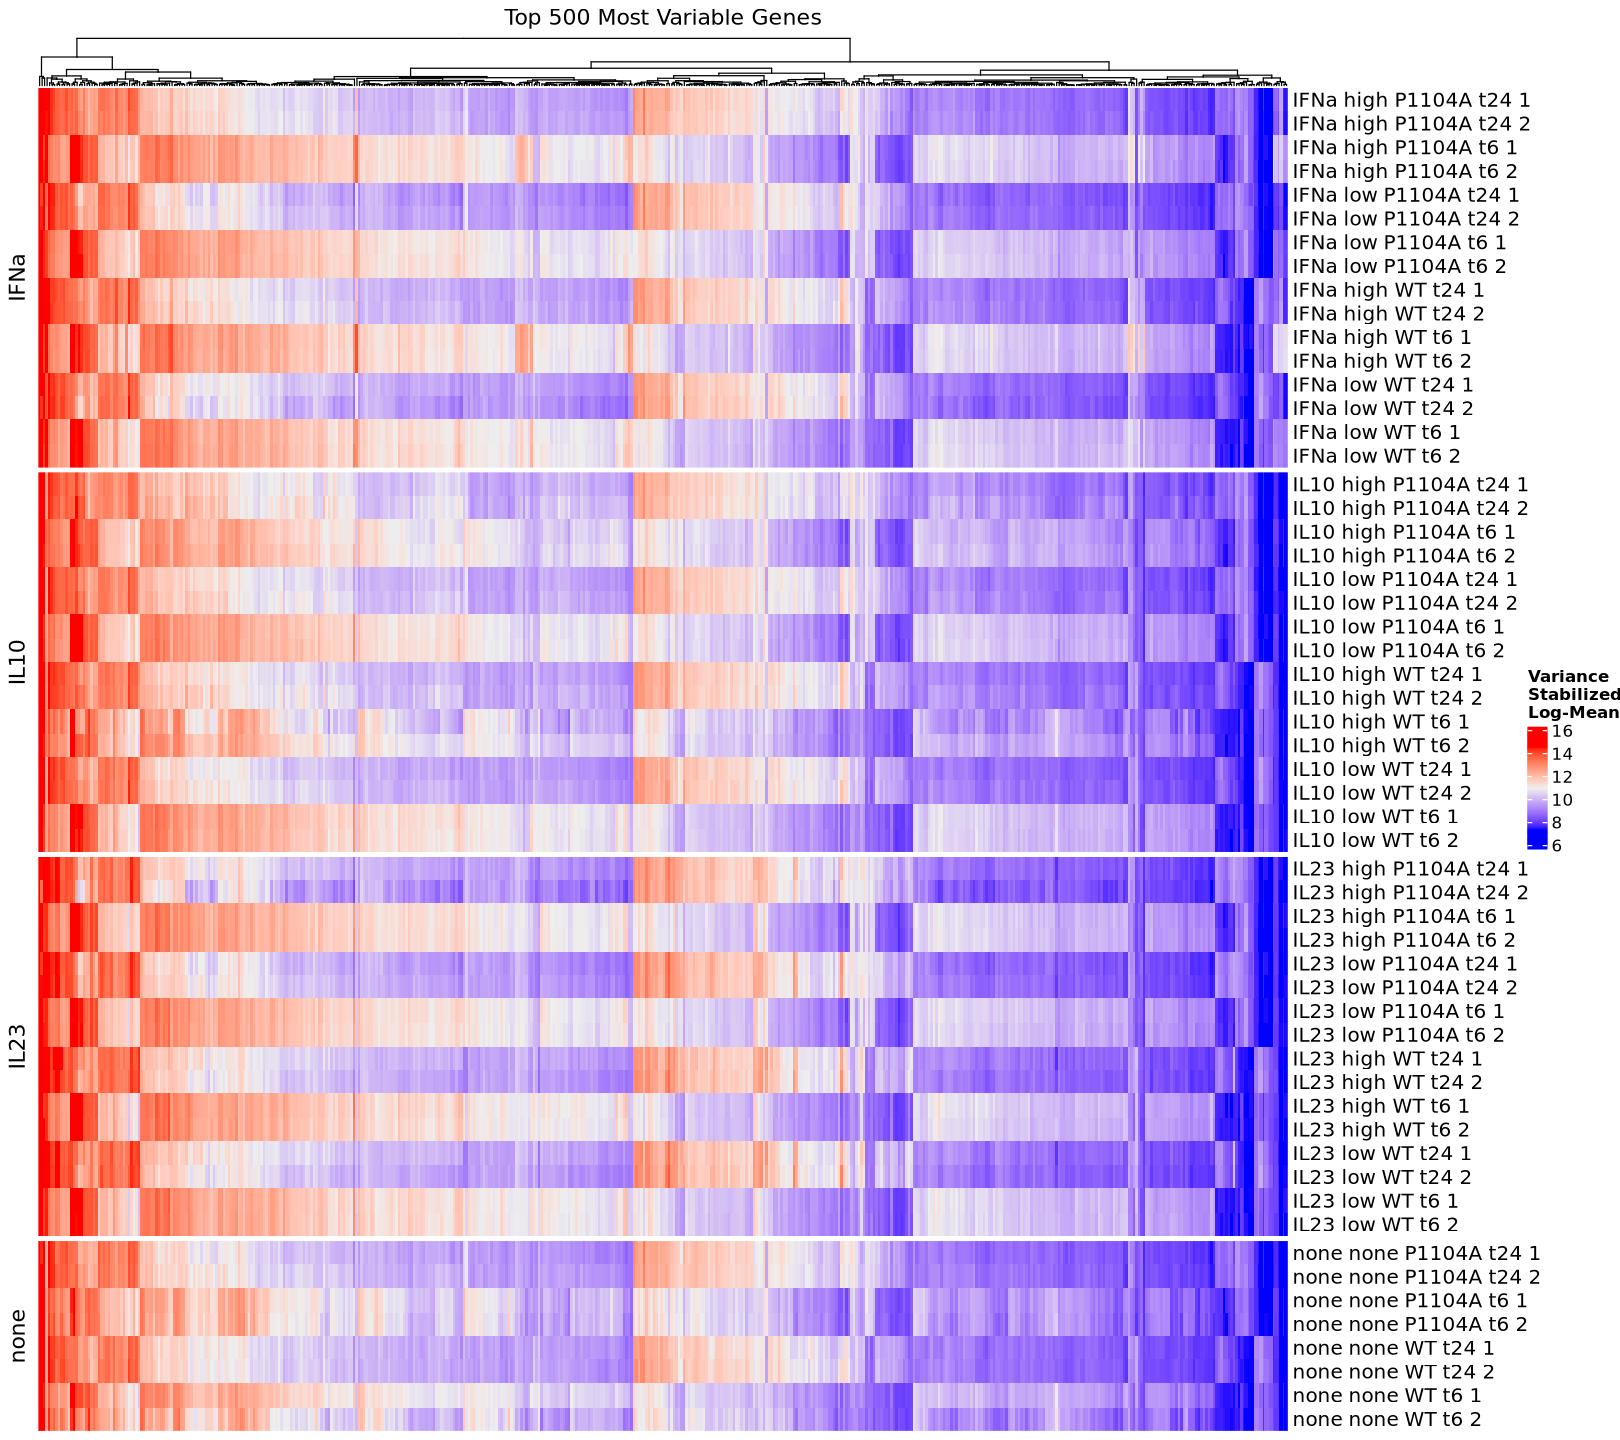

In [57]:
options(repr.plot.width = 13.5, repr.plot.height = 12)
Heatmap(t(as.matrix(vsd_gene_wide_sig[,-1])),
        column_title = "Top 500 Most Variable Genes",
        cluster_columns = TRUE,
        cluster_rows = FALSE,
        row_split = gsub(" .*", "", names(vsd_gene_wide_sig[,-1])),
        use_raster = TRUE,
        raster_by_magick = TRUE,
        name = "Variance\nStabilized\nLog-Mean")

#### Results from Kallisto Quantifications

In [91]:
tx2gene_df <- read_tsv("../data/reference/hg38/kallisto/gencode.v41.pc_transcripts.luciferase.tx2gene.tsv")
abundance_files <- dir_ls(path = "../pipeline/RNASEQ/diffexp/kallisto/",
                          regexp = ".*_kallisto/abundance.h5",
                          recurse = TRUE)
names(abundance_files) <- gsub("../pipeline/RNASEQ/diffexp/kallisto/|_kallisto/abundance.h5",
                               "",
                               abundance_files)

Rows: 110224 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): ENST00000641515.2, OR4F5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [92]:
kallisto_import <- tximport(abundance_files,
                            type = "kallisto",
                            tx2gene = tx2gene_df,
                            ignoreAfterBar = TRUE)

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 


transcripts missing from tx2gene: 1

summarizing abundance

summarizing counts

summarizing length



In [101]:
abundances <- as_tibble(kallisto_import$abundance) %>%
    mutate(gene = rownames(kallisto_import$abundance)) %>%
    pivot_longer(names_to = "sample", values_to = "abundance", -gene)

de_prop <- samp_prop %>%
    filter(!is.na(cytokine)) %>%
    arrange(covariate)
rownames(de_prop) <- str_c(de_prop$sample_id, "_", de_prop$covariate)

de_prop <- de_prop %>% arrange(match(rownames(de_prop), colnames(kallisto_import$counts)))

Warning message:
“Setting row names on a tibble is deprecated.”


In [102]:
deobj_counts <- DESeqDataSetFromTximport(kallisto_import,
    colData = de_prop,
    design = ~covariate)

using counts and average transcript lengths from tximport



In [103]:
deresult <- DESeq(deobj_counts)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [ ]:
cov_group <- de_prop %>%
    filter(!grepl("none", covariate)) %>%
    distinct(covariate) %>%
    pull(covariate) %>%
    as.character()

none_group <- gsub("IFNa|IL10|IL23|low|high", "none", cov_group) %>%
    as.character()

plan(multicore, workers = 25)
norm_result <- future_map2(.x = cov_group,
                    .y = none_group,
                    ~results(deresult,
                             contrast = c("covariate", .x, .y),
                             independentFiltering = FALSE))

In [109]:
sumstats <- map2_dfr(norm_result,
                     cov_group,
                     ~bind_cols("gene" = rownames(kallisto_import$counts),
                                            as_tibble(.x),
                                            "condition" = .y))

In [116]:
sumstats %>%
    separate(condition, c("background", "cytokine", "dosage", "time"), "_") %>%
    write_tsv("../sumstats/RNASEQ/run2/combined/deseq2-kallisto-sumstats-vs-none.tsv")

In [114]:
split_sumstats <- sumstats %>%
    separate(condition, c("background", "cytokine", "dosage", "time"), "_") %>%
    mutate(group = case_when(padj == 1 ~ "FDR = 1",
                             padj < 0.01 ~ "FDR < 0.01",
                             TRUE ~ "NS")) %>%
    mutate(time = relevel(as.factor(time), ref = "t6"),
           dosage = relevel(as.factor(dosage), ref = "low"))

ma_grid <- split_sumstats %>%
    ggplot() +
        geom_point(aes(x = log2(baseMean),
                       y = log2FoldChange,
                       color = group)) +
        theme_pubr(base_size = 15) +
        facet_grid(rows = vars(dosage, time),
                   cols = vars(cytokine, background)) +
        scale_color_manual(values = c("FDR = 1" = "gray",
                                      "NS" = "black",
                                      "FDR < 0.01" = "red"))

Warning message:
“Removed 55416 rows containing missing values (`geom_point()`).”


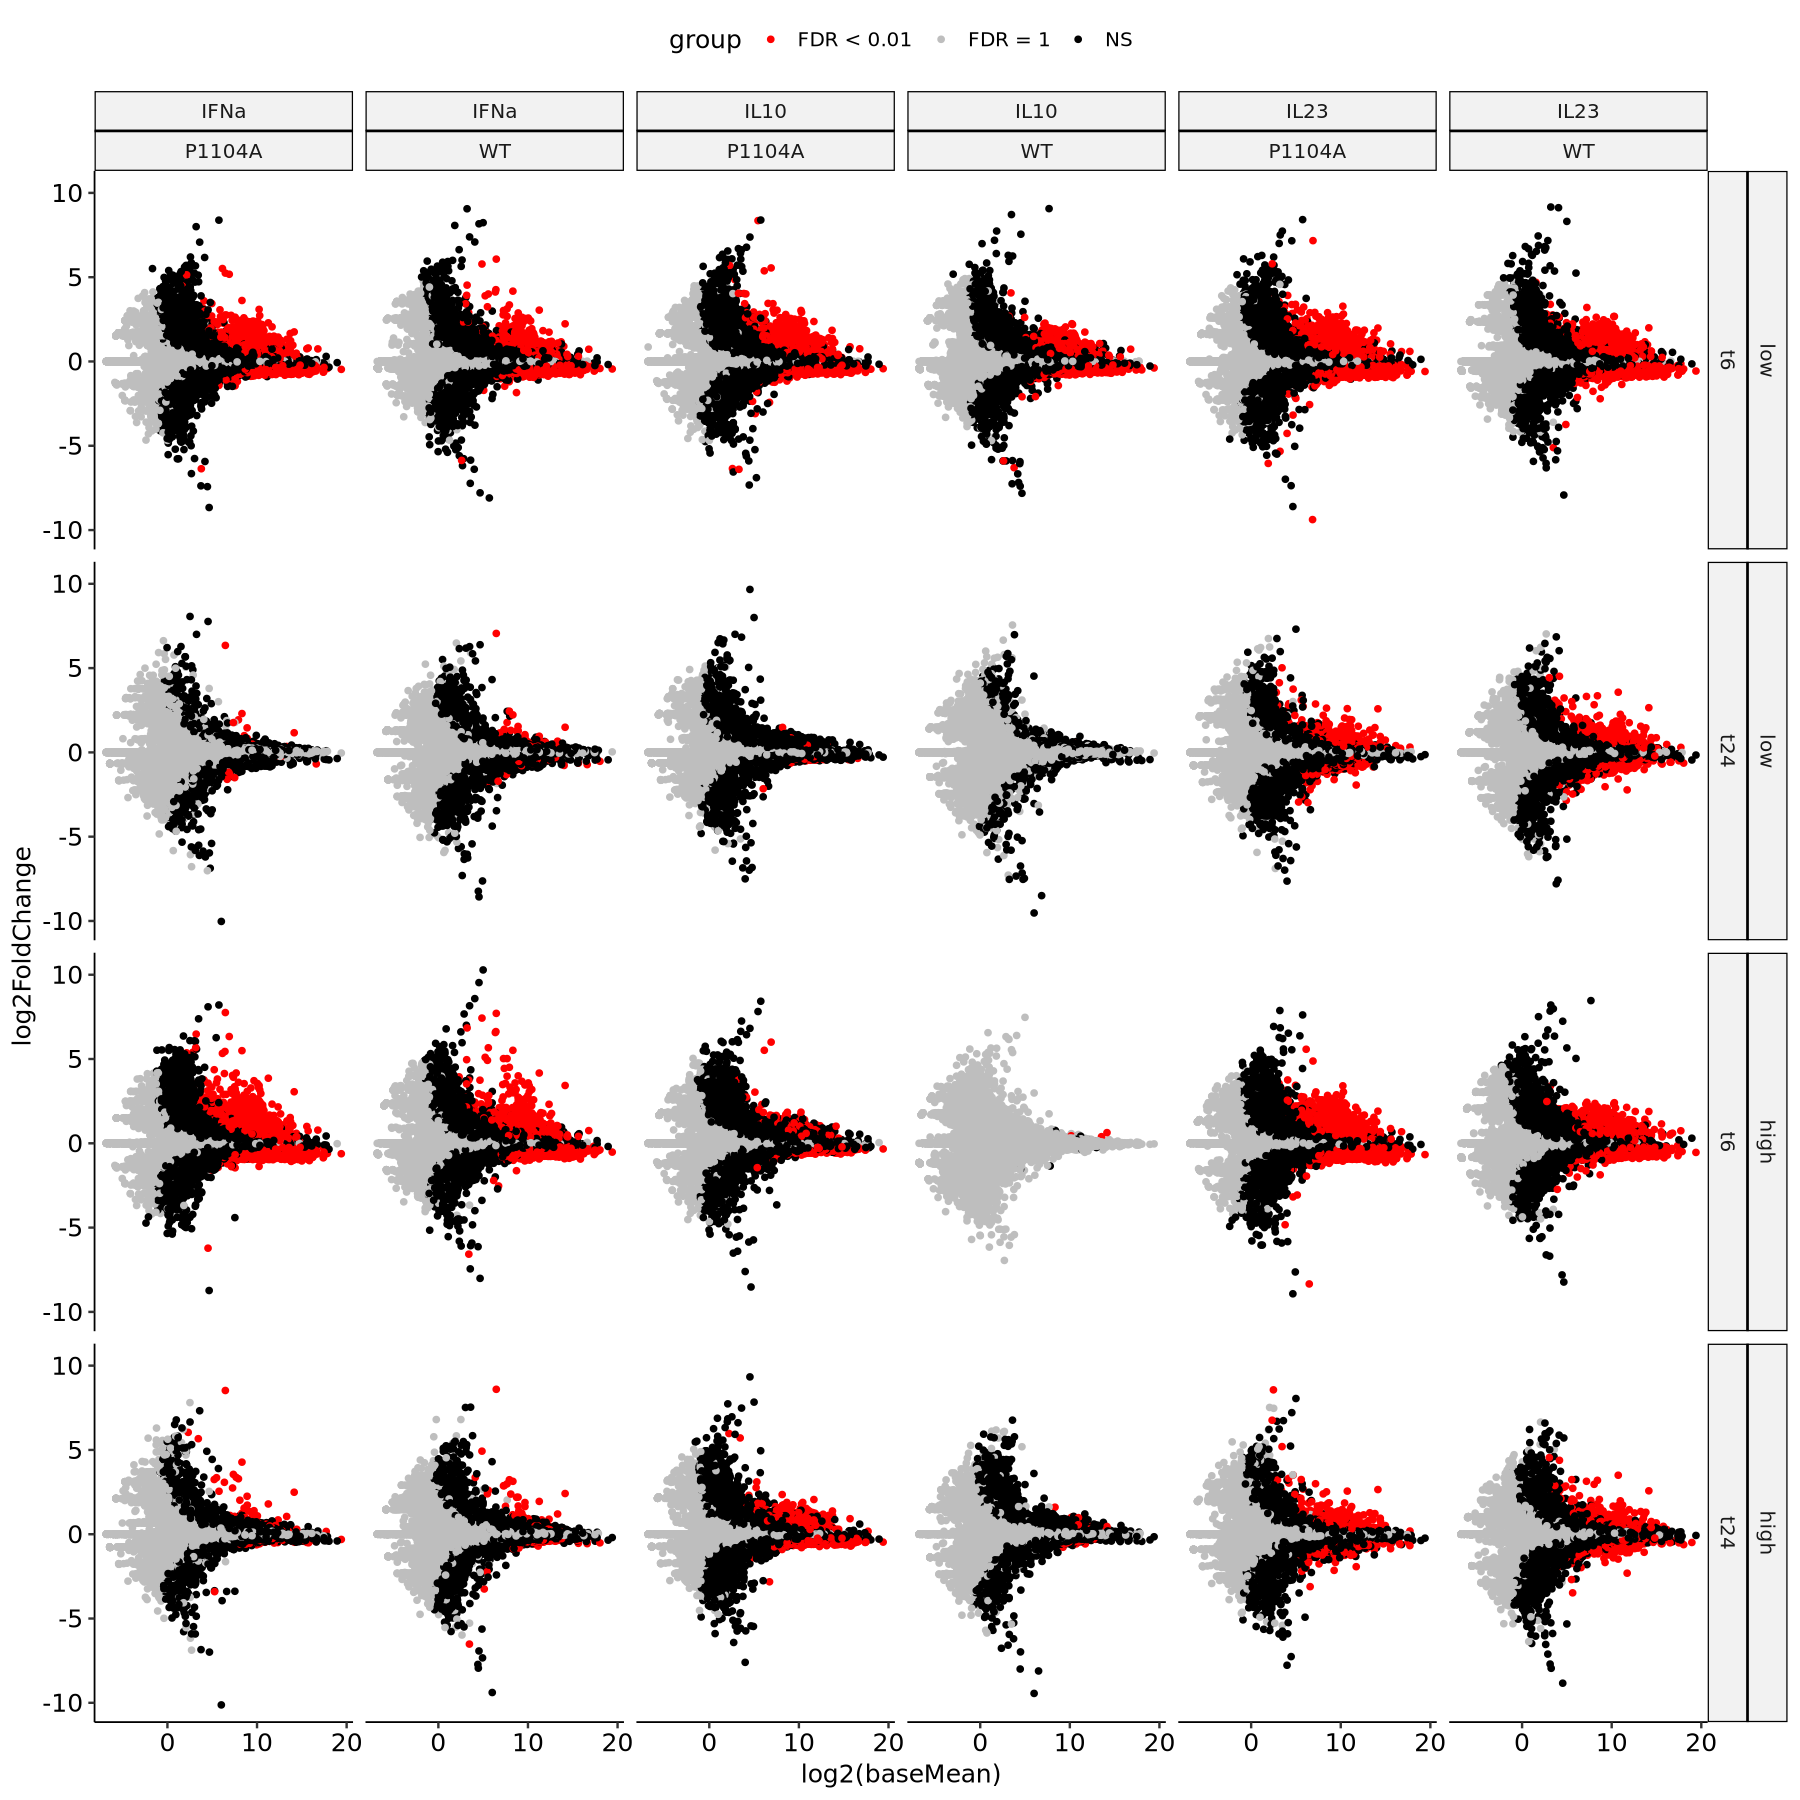

In [115]:
options(repr.plot.width = 15, repr.plot.height = 15)
ma_grid